In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
# Define the coRNNCell
class coRNNCell(nn.Module):
    def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
        super(coRNNCell, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        self.i2h = nn.Linear(n_inp + n_hid + n_hid, n_hid)

    def forward(self, x, hy, hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy), 1)))
                             - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

# Define the coRNN model
class coRNN(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN, self).__init__()
        self.n_hid = n_hid
        self.cell = coRNNCell(n_inp, n_hid, dt, gamma, epsilon)
        self.readout = nn.Linear(n_hid, n_out)

    def forward(self, x):
        hy = torch.zeros(x.size(1), self.n_hid)
        hz = torch.zeros(x.size(1), self.n_hid)

        for t in range(x.size(0)):
            hy, hz = self.cell(x[t], hy, hz)
        output = self.readout(hy)

        return output


In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

(1, 256)
(1, 100)
(256, 100)


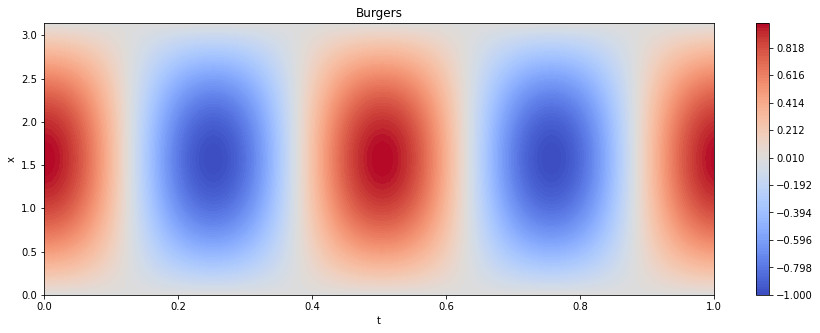

In [3]:
# Load the .mat file
mat_data = scipy.io.loadmat('EB.mat')

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u = mat_data['u1']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u), np.max(u), 100)

# Plot the contour
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burgers')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [4]:
x1 = x.T
t1 = t.T

In [5]:
# Broadcasting to create the u_exact tensor with shape (100, 256)
u_exact = np.sin(x1)[:, np.newaxis] * np.cos(4 * np.pi * t1)

# Now, u_exact will have the shape (100, 256)

u_exact = u_exact.T
u_exact = torch.tensor(u_exact)
u_exact = torch.squeeze(u_exact)
u_exact.shape

torch.Size([100, 256])

In [6]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Toy problem data
input_size = 256
hidden_size = 32
output_size = 256
sequence_length = 79
batch_size = 1
num_epochs = 200000

# Set random seed for reproducibility
torch.manual_seed(42)
u.shape

(256, 100)

In [7]:
input_data = u[:, 0:79]
target_data = u[:, 1:80]

test_data = u[ :, 79]
#test_target = u[:,80:100]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

# Convert data to tensors
input_tensor = torch.tensor(input_data.T).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data.T).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)


test data shape (256,)
input data shape (256, 79)
Target data shape (256, 79)
input tensor shape torch.Size([1, 79, 256])
Target tensor shape torch.Size([1, 79, 256])


In [8]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data.T).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target.T).view(batch_size, 20, output_size).float()
print(test_tensor.shape)

torch.Size([1, 1, 256])


In [9]:
# Create coRNN instance
cornn = coRNN(input_size, hidden_size, output_size, dt=0.1, gamma=1.0, epsilon=0.01)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cornn.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = cornn(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.8f}')





Epoch: 10/200000, Loss: 0.26519510
Epoch: 20/200000, Loss: 0.26073983
Epoch: 30/200000, Loss: 0.25647810
Epoch: 40/200000, Loss: 0.25244465
Epoch: 50/200000, Loss: 0.24865890
Epoch: 60/200000, Loss: 0.24509560
Epoch: 70/200000, Loss: 0.24172626
Epoch: 80/200000, Loss: 0.23852384
Epoch: 90/200000, Loss: 0.23546533
Epoch: 100/200000, Loss: 0.23253144
Epoch: 110/200000, Loss: 0.22970639
Epoch: 120/200000, Loss: 0.22697690
Epoch: 130/200000, Loss: 0.22433199
Epoch: 140/200000, Loss: 0.22176245
Epoch: 150/200000, Loss: 0.21926051
Epoch: 160/200000, Loss: 0.21681952
Epoch: 170/200000, Loss: 0.21443391
Epoch: 180/200000, Loss: 0.21209884
Epoch: 190/200000, Loss: 0.20981023
Epoch: 200/200000, Loss: 0.20756458
Epoch: 210/200000, Loss: 0.20535879
Epoch: 220/200000, Loss: 0.20319031
Epoch: 230/200000, Loss: 0.20105679
Epoch: 240/200000, Loss: 0.19895634
Epoch: 250/200000, Loss: 0.19688718
Epoch: 260/200000, Loss: 0.19484778
Epoch: 270/200000, Loss: 0.19283685


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 79, 256])) that is different to the input size (torch.Size([79, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 280/200000, Loss: 0.19085321
Epoch: 290/200000, Loss: 0.18889576
Epoch: 300/200000, Loss: 0.18696362
Epoch: 310/200000, Loss: 0.18505588
Epoch: 320/200000, Loss: 0.18317182
Epoch: 330/200000, Loss: 0.18131073
Epoch: 340/200000, Loss: 0.17947194
Epoch: 350/200000, Loss: 0.17765488
Epoch: 360/200000, Loss: 0.17585897
Epoch: 370/200000, Loss: 0.17408377
Epoch: 380/200000, Loss: 0.17232867
Epoch: 390/200000, Loss: 0.17059335
Epoch: 400/200000, Loss: 0.16887730
Epoch: 410/200000, Loss: 0.16718014
Epoch: 420/200000, Loss: 0.16550146
Epoch: 430/200000, Loss: 0.16384088
Epoch: 440/200000, Loss: 0.16219810
Epoch: 450/200000, Loss: 0.16057271
Epoch: 460/200000, Loss: 0.15896444
Epoch: 470/200000, Loss: 0.15737303
Epoch: 480/200000, Loss: 0.15579818
Epoch: 490/200000, Loss: 0.15423968
Epoch: 500/200000, Loss: 0.15269732
Epoch: 510/200000, Loss: 0.15117089
Epoch: 520/200000, Loss: 0.14966020
Epoch: 530/200000, Loss: 0.14816509
Epoch: 540/200000, Loss: 0.14668535
Epoch: 550/200000, Loss: 0.1

Epoch: 2560/200000, Loss: 0.01832939
Epoch: 2570/200000, Loss: 0.01813554
Epoch: 2580/200000, Loss: 0.01794371
Epoch: 2590/200000, Loss: 0.01775390
Epoch: 2600/200000, Loss: 0.01756613
Epoch: 2610/200000, Loss: 0.01738041
Epoch: 2620/200000, Loss: 0.01719669
Epoch: 2630/200000, Loss: 0.01701493
Epoch: 2640/200000, Loss: 0.01683508
Epoch: 2650/200000, Loss: 0.01665714
Epoch: 2660/200000, Loss: 0.01648108
Epoch: 2670/200000, Loss: 0.01630687
Epoch: 2680/200000, Loss: 0.01613449
Epoch: 2690/200000, Loss: 0.01596392
Epoch: 2700/200000, Loss: 0.01579513
Epoch: 2710/200000, Loss: 0.01562811
Epoch: 2720/200000, Loss: 0.01546283
Epoch: 2730/200000, Loss: 0.01529926
Epoch: 2740/200000, Loss: 0.01513738
Epoch: 2750/200000, Loss: 0.01497714
Epoch: 2760/200000, Loss: 0.01481850
Epoch: 2770/200000, Loss: 0.01466122
Epoch: 2780/200000, Loss: 0.01450467
Epoch: 2790/200000, Loss: 0.01434969
Epoch: 2800/200000, Loss: 0.01419641
Epoch: 2810/200000, Loss: 0.01404505
Epoch: 2820/200000, Loss: 0.01389568
E

Epoch: 4860/200000, Loss: 0.00169785
Epoch: 4870/200000, Loss: 0.00168703
Epoch: 4880/200000, Loss: 0.00166755
Epoch: 4890/200000, Loss: 0.00165158
Epoch: 4900/200000, Loss: 0.00163640
Epoch: 4910/200000, Loss: 0.00162150
Epoch: 4920/200000, Loss: 0.00160670
Epoch: 4930/200000, Loss: 0.00159200
Epoch: 4940/200000, Loss: 0.00157743
Epoch: 4950/200000, Loss: 0.00156293
Epoch: 4960/200000, Loss: 0.00154848
Epoch: 4970/200000, Loss: 0.00153406
Epoch: 4980/200000, Loss: 0.00151972
Epoch: 4990/200000, Loss: 0.00150916
Epoch: 5000/200000, Loss: 0.00149276
Epoch: 5010/200000, Loss: 0.00147808
Epoch: 5020/200000, Loss: 0.00146386
Epoch: 5030/200000, Loss: 0.00145002
Epoch: 5040/200000, Loss: 0.00143652
Epoch: 5050/200000, Loss: 0.00142326
Epoch: 5060/200000, Loss: 0.00141011
Epoch: 5070/200000, Loss: 0.00139712
Epoch: 5080/200000, Loss: 0.00138428
Epoch: 5090/200000, Loss: 0.00137157
Epoch: 5100/200000, Loss: 0.00135901
Epoch: 5110/200000, Loss: 0.00134659
Epoch: 5120/200000, Loss: 0.00133464
E

Epoch: 7190/200000, Loss: 0.00038957
Epoch: 7200/200000, Loss: 0.00038842
Epoch: 7210/200000, Loss: 0.00038729
Epoch: 7220/200000, Loss: 0.00038616
Epoch: 7230/200000, Loss: 0.00038546
Epoch: 7240/200000, Loss: 0.00039155
Epoch: 7250/200000, Loss: 0.00038478
Epoch: 7260/200000, Loss: 0.00038183
Epoch: 7270/200000, Loss: 0.00038082
Epoch: 7280/200000, Loss: 0.00037981
Epoch: 7290/200000, Loss: 0.00037862
Epoch: 7300/200000, Loss: 0.00037757
Epoch: 7310/200000, Loss: 0.00037653
Epoch: 7320/200000, Loss: 0.00037549
Epoch: 7330/200000, Loss: 0.00037447
Epoch: 7340/200000, Loss: 0.00037345
Epoch: 7350/200000, Loss: 0.00037244
Epoch: 7360/200000, Loss: 0.00037143
Epoch: 7370/200000, Loss: 0.00037043
Epoch: 7380/200000, Loss: 0.00036944
Epoch: 7390/200000, Loss: 0.00036846
Epoch: 7400/200000, Loss: 0.00036748
Epoch: 7410/200000, Loss: 0.00036652
Epoch: 7420/200000, Loss: 0.00036801
Epoch: 7430/200000, Loss: 0.00036761
Epoch: 7440/200000, Loss: 0.00036367
Epoch: 7450/200000, Loss: 0.00036285
E

Epoch: 9530/200000, Loss: 0.00024679
Epoch: 9540/200000, Loss: 0.00024724
Epoch: 9550/200000, Loss: 0.00025461
Epoch: 9560/200000, Loss: 0.00025127
Epoch: 9570/200000, Loss: 0.00024753
Epoch: 9580/200000, Loss: 0.00024601
Epoch: 9590/200000, Loss: 0.00024527
Epoch: 9600/200000, Loss: 0.00024484
Epoch: 9610/200000, Loss: 0.00024455
Epoch: 9620/200000, Loss: 0.00024428
Epoch: 9630/200000, Loss: 0.00024400
Epoch: 9640/200000, Loss: 0.00024372
Epoch: 9650/200000, Loss: 0.00024345
Epoch: 9660/200000, Loss: 0.00024317
Epoch: 9670/200000, Loss: 0.00024290
Epoch: 9680/200000, Loss: 0.00024262
Epoch: 9690/200000, Loss: 0.00024235
Epoch: 9700/200000, Loss: 0.00024208
Epoch: 9710/200000, Loss: 0.00024180
Epoch: 9720/200000, Loss: 0.00024153
Epoch: 9730/200000, Loss: 0.00024126
Epoch: 9740/200000, Loss: 0.00024099
Epoch: 9750/200000, Loss: 0.00024071
Epoch: 9760/200000, Loss: 0.00024044
Epoch: 9770/200000, Loss: 0.00024025
Epoch: 9780/200000, Loss: 0.00025179
Epoch: 9790/200000, Loss: 0.00024645
E

Epoch: 11760/200000, Loss: 0.00019660
Epoch: 11770/200000, Loss: 0.00019633
Epoch: 11780/200000, Loss: 0.00019601
Epoch: 11790/200000, Loss: 0.00019583
Epoch: 11800/200000, Loss: 0.00019561
Epoch: 11810/200000, Loss: 0.00019541
Epoch: 11820/200000, Loss: 0.00019521
Epoch: 11830/200000, Loss: 0.00019500
Epoch: 11840/200000, Loss: 0.00019480
Epoch: 11850/200000, Loss: 0.00019460
Epoch: 11860/200000, Loss: 0.00019439
Epoch: 11870/200000, Loss: 0.00019418
Epoch: 11880/200000, Loss: 0.00019398
Epoch: 11890/200000, Loss: 0.00019377
Epoch: 11900/200000, Loss: 0.00019357
Epoch: 11910/200000, Loss: 0.00019336
Epoch: 11920/200000, Loss: 0.00019315
Epoch: 11930/200000, Loss: 0.00019294
Epoch: 11940/200000, Loss: 0.00019295
Epoch: 11950/200000, Loss: 0.00022930
Epoch: 11960/200000, Loss: 0.00020024
Epoch: 11970/200000, Loss: 0.00019577
Epoch: 11980/200000, Loss: 0.00019266
Epoch: 11990/200000, Loss: 0.00019180
Epoch: 12000/200000, Loss: 0.00019158
Epoch: 12010/200000, Loss: 0.00019139
Epoch: 12020

Epoch: 13920/200000, Loss: 0.00015381
Epoch: 13930/200000, Loss: 0.00015361
Epoch: 13940/200000, Loss: 0.00015343
Epoch: 13950/200000, Loss: 0.00015659
Epoch: 13960/200000, Loss: 0.00015552
Epoch: 13970/200000, Loss: 0.00015290
Epoch: 13980/200000, Loss: 0.00015273
Epoch: 13990/200000, Loss: 0.00015252
Epoch: 14000/200000, Loss: 0.00015232
Epoch: 14010/200000, Loss: 0.00015214
Epoch: 14020/200000, Loss: 0.00015196
Epoch: 14030/200000, Loss: 0.00015178
Epoch: 14040/200000, Loss: 0.00015158
Epoch: 14050/200000, Loss: 0.00015139
Epoch: 14060/200000, Loss: 0.00015121
Epoch: 14070/200000, Loss: 0.00015102
Epoch: 14080/200000, Loss: 0.00015083
Epoch: 14090/200000, Loss: 0.00015065
Epoch: 14100/200000, Loss: 0.00015046
Epoch: 14110/200000, Loss: 0.00015027
Epoch: 14120/200000, Loss: 0.00015008
Epoch: 14130/200000, Loss: 0.00014989
Epoch: 14140/200000, Loss: 0.00014970
Epoch: 14150/200000, Loss: 0.00014951
Epoch: 14160/200000, Loss: 0.00014932
Epoch: 14170/200000, Loss: 0.00014913
Epoch: 14180

Epoch: 16140/200000, Loss: 0.00011482
Epoch: 16150/200000, Loss: 0.00011466
Epoch: 16160/200000, Loss: 0.00011451
Epoch: 16170/200000, Loss: 0.00011435
Epoch: 16180/200000, Loss: 0.00011419
Epoch: 16190/200000, Loss: 0.00011403
Epoch: 16200/200000, Loss: 0.00011387
Epoch: 16210/200000, Loss: 0.00011371
Epoch: 16220/200000, Loss: 0.00011355
Epoch: 16230/200000, Loss: 0.00011339
Epoch: 16240/200000, Loss: 0.00011323
Epoch: 16250/200000, Loss: 0.00011307
Epoch: 16260/200000, Loss: 0.00011291
Epoch: 16270/200000, Loss: 0.00011278
Epoch: 16280/200000, Loss: 0.00011592
Epoch: 16290/200000, Loss: 0.00011271
Epoch: 16300/200000, Loss: 0.00011720
Epoch: 16310/200000, Loss: 0.00011333
Epoch: 16320/200000, Loss: 0.00011199
Epoch: 16330/200000, Loss: 0.00011204
Epoch: 16340/200000, Loss: 0.00011170
Epoch: 16350/200000, Loss: 0.00011154
Epoch: 16360/200000, Loss: 0.00011137
Epoch: 16370/200000, Loss: 0.00011121
Epoch: 16380/200000, Loss: 0.00011106
Epoch: 16390/200000, Loss: 0.00011090
Epoch: 16400

Epoch: 18380/200000, Loss: 0.00008417
Epoch: 18390/200000, Loss: 0.00010865
Epoch: 18400/200000, Loss: 0.00009153
Epoch: 18410/200000, Loss: 0.00008735
Epoch: 18420/200000, Loss: 0.00008404
Epoch: 18430/200000, Loss: 0.00008337
Epoch: 18440/200000, Loss: 0.00008340
Epoch: 18450/200000, Loss: 0.00008315
Epoch: 18460/200000, Loss: 0.00008303
Epoch: 18470/200000, Loss: 0.00008290
Epoch: 18480/200000, Loss: 0.00008279
Epoch: 18490/200000, Loss: 0.00008267
Epoch: 18500/200000, Loss: 0.00008255
Epoch: 18510/200000, Loss: 0.00008244
Epoch: 18520/200000, Loss: 0.00008232
Epoch: 18530/200000, Loss: 0.00008221
Epoch: 18540/200000, Loss: 0.00008209
Epoch: 18550/200000, Loss: 0.00008198
Epoch: 18560/200000, Loss: 0.00008186
Epoch: 18570/200000, Loss: 0.00008175
Epoch: 18580/200000, Loss: 0.00008163
Epoch: 18590/200000, Loss: 0.00008165
Epoch: 18600/200000, Loss: 0.00009462
Epoch: 18610/200000, Loss: 0.00009248
Epoch: 18620/200000, Loss: 0.00008129
Epoch: 18630/200000, Loss: 0.00008191
Epoch: 18640

Epoch: 20550/200000, Loss: 0.00006294
Epoch: 20560/200000, Loss: 0.00006286
Epoch: 20570/200000, Loss: 0.00006278
Epoch: 20580/200000, Loss: 0.00006271
Epoch: 20590/200000, Loss: 0.00006263
Epoch: 20600/200000, Loss: 0.00006255
Epoch: 20610/200000, Loss: 0.00006247
Epoch: 20620/200000, Loss: 0.00006239
Epoch: 20630/200000, Loss: 0.00006231
Epoch: 20640/200000, Loss: 0.00006223
Epoch: 20650/200000, Loss: 0.00006215
Epoch: 20660/200000, Loss: 0.00006208
Epoch: 20670/200000, Loss: 0.00006218
Epoch: 20680/200000, Loss: 0.00007583
Epoch: 20690/200000, Loss: 0.00007204
Epoch: 20700/200000, Loss: 0.00006199
Epoch: 20710/200000, Loss: 0.00006321
Epoch: 20720/200000, Loss: 0.00006174
Epoch: 20730/200000, Loss: 0.00006172
Epoch: 20740/200000, Loss: 0.00006148
Epoch: 20750/200000, Loss: 0.00006143
Epoch: 20760/200000, Loss: 0.00006133
Epoch: 20770/200000, Loss: 0.00006125
Epoch: 20780/200000, Loss: 0.00006117
Epoch: 20790/200000, Loss: 0.00006110
Epoch: 20800/200000, Loss: 0.00006102
Epoch: 20810

Epoch: 22730/200000, Loss: 0.00005392
Epoch: 22740/200000, Loss: 0.00005610
Epoch: 22750/200000, Loss: 0.00004945
Epoch: 22760/200000, Loss: 0.00004926
Epoch: 22770/200000, Loss: 0.00004924
Epoch: 22780/200000, Loss: 0.00004886
Epoch: 22790/200000, Loss: 0.00004886
Epoch: 22800/200000, Loss: 0.00004877
Epoch: 22810/200000, Loss: 0.00004871
Epoch: 22820/200000, Loss: 0.00004866
Epoch: 22830/200000, Loss: 0.00004861
Epoch: 22840/200000, Loss: 0.00004856
Epoch: 22850/200000, Loss: 0.00004851
Epoch: 22860/200000, Loss: 0.00004846
Epoch: 22870/200000, Loss: 0.00004841
Epoch: 22880/200000, Loss: 0.00004836
Epoch: 22890/200000, Loss: 0.00004831
Epoch: 22900/200000, Loss: 0.00004826
Epoch: 22910/200000, Loss: 0.00004824
Epoch: 22920/200000, Loss: 0.00004978
Epoch: 22930/200000, Loss: 0.00007232
Epoch: 22940/200000, Loss: 0.00004889
Epoch: 22950/200000, Loss: 0.00004957
Epoch: 22960/200000, Loss: 0.00004892
Epoch: 22970/200000, Loss: 0.00004795
Epoch: 22980/200000, Loss: 0.00004803
Epoch: 22990

Epoch: 24900/200000, Loss: 0.00004040
Epoch: 24910/200000, Loss: 0.00004049
Epoch: 24920/200000, Loss: 0.00004028
Epoch: 24930/200000, Loss: 0.00004025
Epoch: 24940/200000, Loss: 0.00004018
Epoch: 24950/200000, Loss: 0.00004015
Epoch: 24960/200000, Loss: 0.00004012
Epoch: 24970/200000, Loss: 0.00004009
Epoch: 24980/200000, Loss: 0.00004005
Epoch: 24990/200000, Loss: 0.00004002
Epoch: 25000/200000, Loss: 0.00003999
Epoch: 25010/200000, Loss: 0.00003996
Epoch: 25020/200000, Loss: 0.00003992
Epoch: 25030/200000, Loss: 0.00003989
Epoch: 25040/200000, Loss: 0.00003986
Epoch: 25050/200000, Loss: 0.00003996
Epoch: 25060/200000, Loss: 0.00004983
Epoch: 25070/200000, Loss: 0.00004361
Epoch: 25080/200000, Loss: 0.00004339
Epoch: 25090/200000, Loss: 0.00004144
Epoch: 25100/200000, Loss: 0.00003971
Epoch: 25110/200000, Loss: 0.00003993
Epoch: 25120/200000, Loss: 0.00003962
Epoch: 25130/200000, Loss: 0.00003961
Epoch: 25140/200000, Loss: 0.00003957
Epoch: 25150/200000, Loss: 0.00003952
Epoch: 25160

Epoch: 27090/200000, Loss: 0.00003464
Epoch: 27100/200000, Loss: 0.00003618
Epoch: 27110/200000, Loss: 0.00003502
Epoch: 27120/200000, Loss: 0.00003456
Epoch: 27130/200000, Loss: 0.00003458
Epoch: 27140/200000, Loss: 0.00003449
Epoch: 27150/200000, Loss: 0.00003445
Epoch: 27160/200000, Loss: 0.00003444
Epoch: 27170/200000, Loss: 0.00003441
Epoch: 27180/200000, Loss: 0.00003439
Epoch: 27190/200000, Loss: 0.00003437
Epoch: 27200/200000, Loss: 0.00003435
Epoch: 27210/200000, Loss: 0.00003432
Epoch: 27220/200000, Loss: 0.00003430
Epoch: 27230/200000, Loss: 0.00003428
Epoch: 27240/200000, Loss: 0.00003426
Epoch: 27250/200000, Loss: 0.00003424
Epoch: 27260/200000, Loss: 0.00003422
Epoch: 27270/200000, Loss: 0.00003440
Epoch: 27280/200000, Loss: 0.00005911
Epoch: 27290/200000, Loss: 0.00005358
Epoch: 27300/200000, Loss: 0.00003853
Epoch: 27310/200000, Loss: 0.00003461
Epoch: 27320/200000, Loss: 0.00003413
Epoch: 27330/200000, Loss: 0.00003428
Epoch: 27340/200000, Loss: 0.00003416
Epoch: 27350

Epoch: 29270/200000, Loss: 0.00003076
Epoch: 29280/200000, Loss: 0.00003074
Epoch: 29290/200000, Loss: 0.00003073
Epoch: 29300/200000, Loss: 0.00003071
Epoch: 29310/200000, Loss: 0.00003070
Epoch: 29320/200000, Loss: 0.00003068
Epoch: 29330/200000, Loss: 0.00003067
Epoch: 29340/200000, Loss: 0.00003065
Epoch: 29350/200000, Loss: 0.00003064
Epoch: 29360/200000, Loss: 0.00003062
Epoch: 29370/200000, Loss: 0.00003061
Epoch: 29380/200000, Loss: 0.00003061
Epoch: 29390/200000, Loss: 0.00003152
Epoch: 29400/200000, Loss: 0.00007059
Epoch: 29410/200000, Loss: 0.00003246
Epoch: 29420/200000, Loss: 0.00003477
Epoch: 29430/200000, Loss: 0.00003121
Epoch: 29440/200000, Loss: 0.00003062
Epoch: 29450/200000, Loss: 0.00003070
Epoch: 29460/200000, Loss: 0.00003049
Epoch: 29470/200000, Loss: 0.00003049
Epoch: 29480/200000, Loss: 0.00003046
Epoch: 29490/200000, Loss: 0.00003044
Epoch: 29500/200000, Loss: 0.00003043
Epoch: 29510/200000, Loss: 0.00003041
Epoch: 29520/200000, Loss: 0.00003040
Epoch: 29530

Epoch: 31460/200000, Loss: 0.00003577
Epoch: 31470/200000, Loss: 0.00002803
Epoch: 31480/200000, Loss: 0.00003409
Epoch: 31490/200000, Loss: 0.00002800
Epoch: 31500/200000, Loss: 0.00002875
Epoch: 31510/200000, Loss: 0.00002797
Epoch: 31520/200000, Loss: 0.00002797
Epoch: 31530/200000, Loss: 0.00002795
Epoch: 31540/200000, Loss: 0.00002790
Epoch: 31550/200000, Loss: 0.00002788
Epoch: 31560/200000, Loss: 0.00002787
Epoch: 31570/200000, Loss: 0.00002786
Epoch: 31580/200000, Loss: 0.00002785
Epoch: 31590/200000, Loss: 0.00002783
Epoch: 31600/200000, Loss: 0.00002782
Epoch: 31610/200000, Loss: 0.00002781
Epoch: 31620/200000, Loss: 0.00002780
Epoch: 31630/200000, Loss: 0.00002779
Epoch: 31640/200000, Loss: 0.00002787
Epoch: 31650/200000, Loss: 0.00004231
Epoch: 31660/200000, Loss: 0.00004607
Epoch: 31670/200000, Loss: 0.00002882
Epoch: 31680/200000, Loss: 0.00002777
Epoch: 31690/200000, Loss: 0.00002786
Epoch: 31700/200000, Loss: 0.00002795
Epoch: 31710/200000, Loss: 0.00002785
Epoch: 31720

Epoch: 33730/200000, Loss: 0.00002571
Epoch: 33740/200000, Loss: 0.00002570
Epoch: 33750/200000, Loss: 0.00002569
Epoch: 33760/200000, Loss: 0.00002568
Epoch: 33770/200000, Loss: 0.00002567
Epoch: 33780/200000, Loss: 0.00002566
Epoch: 33790/200000, Loss: 0.00002565
Epoch: 33800/200000, Loss: 0.00002575
Epoch: 33810/200000, Loss: 0.00003769
Epoch: 33820/200000, Loss: 0.00003513
Epoch: 33830/200000, Loss: 0.00002630
Epoch: 33840/200000, Loss: 0.00002743
Epoch: 33850/200000, Loss: 0.00002668
Epoch: 33860/200000, Loss: 0.00002579
Epoch: 33870/200000, Loss: 0.00002561
Epoch: 33880/200000, Loss: 0.00002563
Epoch: 33890/200000, Loss: 0.00002557
Epoch: 33900/200000, Loss: 0.00002557
Epoch: 33910/200000, Loss: 0.00002556
Epoch: 33920/200000, Loss: 0.00002555
Epoch: 33930/200000, Loss: 0.00002554
Epoch: 33940/200000, Loss: 0.00002553
Epoch: 33950/200000, Loss: 0.00002552
Epoch: 33960/200000, Loss: 0.00002551
Epoch: 33970/200000, Loss: 0.00002550
Epoch: 33980/200000, Loss: 0.00002549
Epoch: 33990

Epoch: 35890/200000, Loss: 0.00002632
Epoch: 35900/200000, Loss: 0.00002416
Epoch: 35910/200000, Loss: 0.00002417
Epoch: 35920/200000, Loss: 0.00002401
Epoch: 35930/200000, Loss: 0.00002399
Epoch: 35940/200000, Loss: 0.00002395
Epoch: 35950/200000, Loss: 0.00002394
Epoch: 35960/200000, Loss: 0.00002394
Epoch: 35970/200000, Loss: 0.00002393
Epoch: 35980/200000, Loss: 0.00002392
Epoch: 35990/200000, Loss: 0.00002391
Epoch: 36000/200000, Loss: 0.00002391
Epoch: 36010/200000, Loss: 0.00002390
Epoch: 36020/200000, Loss: 0.00002389
Epoch: 36030/200000, Loss: 0.00002388
Epoch: 36040/200000, Loss: 0.00002388
Epoch: 36050/200000, Loss: 0.00002387
Epoch: 36060/200000, Loss: 0.00002432
Epoch: 36070/200000, Loss: 0.00006476
Epoch: 36080/200000, Loss: 0.00003482
Epoch: 36090/200000, Loss: 0.00002992
Epoch: 36100/200000, Loss: 0.00002514
Epoch: 36110/200000, Loss: 0.00002388
Epoch: 36120/200000, Loss: 0.00002397
Epoch: 36130/200000, Loss: 0.00002392
Epoch: 36140/200000, Loss: 0.00002381
Epoch: 36150

Epoch: 38050/200000, Loss: 0.00002259
Epoch: 38060/200000, Loss: 0.00002258
Epoch: 38070/200000, Loss: 0.00002258
Epoch: 38080/200000, Loss: 0.00002257
Epoch: 38090/200000, Loss: 0.00002257
Epoch: 38100/200000, Loss: 0.00002256
Epoch: 38110/200000, Loss: 0.00002255
Epoch: 38120/200000, Loss: 0.00002255
Epoch: 38130/200000, Loss: 0.00002254
Epoch: 38140/200000, Loss: 0.00002253
Epoch: 38150/200000, Loss: 0.00002253
Epoch: 38160/200000, Loss: 0.00002252
Epoch: 38170/200000, Loss: 0.00002255
Epoch: 38180/200000, Loss: 0.00003045
Epoch: 38190/200000, Loss: 0.00002996
Epoch: 38200/200000, Loss: 0.00002281
Epoch: 38210/200000, Loss: 0.00002298
Epoch: 38220/200000, Loss: 0.00002289
Epoch: 38230/200000, Loss: 0.00002266
Epoch: 38240/200000, Loss: 0.00002253
Epoch: 38250/200000, Loss: 0.00002248
Epoch: 38260/200000, Loss: 0.00002248
Epoch: 38270/200000, Loss: 0.00002247
Epoch: 38280/200000, Loss: 0.00002246
Epoch: 38290/200000, Loss: 0.00002245
Epoch: 38300/200000, Loss: 0.00002245
Epoch: 38310

Epoch: 40450/200000, Loss: 0.00002178
Epoch: 40460/200000, Loss: 0.00002451
Epoch: 40470/200000, Loss: 0.00002323
Epoch: 40480/200000, Loss: 0.00002177
Epoch: 40490/200000, Loss: 0.00002127
Epoch: 40500/200000, Loss: 0.00002133
Epoch: 40510/200000, Loss: 0.00002127
Epoch: 40520/200000, Loss: 0.00002125
Epoch: 40530/200000, Loss: 0.00002124
Epoch: 40540/200000, Loss: 0.00002124
Epoch: 40550/200000, Loss: 0.00002123
Epoch: 40560/200000, Loss: 0.00002122
Epoch: 40570/200000, Loss: 0.00002122
Epoch: 40580/200000, Loss: 0.00002121
Epoch: 40590/200000, Loss: 0.00002121
Epoch: 40600/200000, Loss: 0.00002120
Epoch: 40610/200000, Loss: 0.00002120
Epoch: 40620/200000, Loss: 0.00002119
Epoch: 40630/200000, Loss: 0.00002119
Epoch: 40640/200000, Loss: 0.00002119
Epoch: 40650/200000, Loss: 0.00002120
Epoch: 40660/200000, Loss: 0.00002267
Epoch: 40670/200000, Loss: 0.00006051
Epoch: 40680/200000, Loss: 0.00002188
Epoch: 40690/200000, Loss: 0.00002530
Epoch: 40700/200000, Loss: 0.00002158
Epoch: 40710

Epoch: 42650/200000, Loss: 0.00002213
Epoch: 42660/200000, Loss: 0.00005940
Epoch: 42670/200000, Loss: 0.00002143
Epoch: 42680/200000, Loss: 0.00002183
Epoch: 42690/200000, Loss: 0.00002190
Epoch: 42700/200000, Loss: 0.00002052
Epoch: 42710/200000, Loss: 0.00002036
Epoch: 42720/200000, Loss: 0.00002036
Epoch: 42730/200000, Loss: 0.00002029
Epoch: 42740/200000, Loss: 0.00002029
Epoch: 42750/200000, Loss: 0.00002028
Epoch: 42760/200000, Loss: 0.00002027
Epoch: 42770/200000, Loss: 0.00002027
Epoch: 42780/200000, Loss: 0.00002026
Epoch: 42790/200000, Loss: 0.00002026
Epoch: 42800/200000, Loss: 0.00002025
Epoch: 42810/200000, Loss: 0.00002025
Epoch: 42820/200000, Loss: 0.00002024
Epoch: 42830/200000, Loss: 0.00002024
Epoch: 42840/200000, Loss: 0.00002024
Epoch: 42850/200000, Loss: 0.00002023
Epoch: 42860/200000, Loss: 0.00002039
Epoch: 42870/200000, Loss: 0.00003390
Epoch: 42880/200000, Loss: 0.00002738
Epoch: 42890/200000, Loss: 0.00002340
Epoch: 42900/200000, Loss: 0.00002284
Epoch: 42910

Epoch: 44860/200000, Loss: 0.00001949
Epoch: 44870/200000, Loss: 0.00001948
Epoch: 44880/200000, Loss: 0.00001948
Epoch: 44890/200000, Loss: 0.00001948
Epoch: 44900/200000, Loss: 0.00001947
Epoch: 44910/200000, Loss: 0.00001947
Epoch: 44920/200000, Loss: 0.00001947
Epoch: 44930/200000, Loss: 0.00001963
Epoch: 44940/200000, Loss: 0.00003775
Epoch: 44950/200000, Loss: 0.00003672
Epoch: 44960/200000, Loss: 0.00001951
Epoch: 44970/200000, Loss: 0.00002047
Epoch: 44980/200000, Loss: 0.00002046
Epoch: 44990/200000, Loss: 0.00001969
Epoch: 45000/200000, Loss: 0.00001946
Epoch: 45010/200000, Loss: 0.00001949
Epoch: 45020/200000, Loss: 0.00001944
Epoch: 45030/200000, Loss: 0.00001944
Epoch: 45040/200000, Loss: 0.00001943
Epoch: 45050/200000, Loss: 0.00001942
Epoch: 45060/200000, Loss: 0.00001942
Epoch: 45070/200000, Loss: 0.00001942
Epoch: 45080/200000, Loss: 0.00001941
Epoch: 45090/200000, Loss: 0.00001941
Epoch: 45100/200000, Loss: 0.00001940
Epoch: 45110/200000, Loss: 0.00001940
Epoch: 45120

Epoch: 47060/200000, Loss: 0.00001879
Epoch: 47070/200000, Loss: 0.00001877
Epoch: 47080/200000, Loss: 0.00001875
Epoch: 47090/200000, Loss: 0.00001875
Epoch: 47100/200000, Loss: 0.00001875
Epoch: 47110/200000, Loss: 0.00001874
Epoch: 47120/200000, Loss: 0.00001874
Epoch: 47130/200000, Loss: 0.00001874
Epoch: 47140/200000, Loss: 0.00001873
Epoch: 47150/200000, Loss: 0.00001873
Epoch: 47160/200000, Loss: 0.00001872
Epoch: 47170/200000, Loss: 0.00001872
Epoch: 47180/200000, Loss: 0.00001873
Epoch: 47190/200000, Loss: 0.00001921
Epoch: 47200/200000, Loss: 0.00005870
Epoch: 47210/200000, Loss: 0.00003350
Epoch: 47220/200000, Loss: 0.00002400
Epoch: 47230/200000, Loss: 0.00001909
Epoch: 47240/200000, Loss: 0.00001885
Epoch: 47250/200000, Loss: 0.00001900
Epoch: 47260/200000, Loss: 0.00001873
Epoch: 47270/200000, Loss: 0.00001872
Epoch: 47280/200000, Loss: 0.00001870
Epoch: 47290/200000, Loss: 0.00001869
Epoch: 47300/200000, Loss: 0.00001868
Epoch: 47310/200000, Loss: 0.00001868
Epoch: 47320

Epoch: 49260/200000, Loss: 0.00006830
Epoch: 49270/200000, Loss: 0.00002312
Epoch: 49280/200000, Loss: 0.00002393
Epoch: 49290/200000, Loss: 0.00001946
Epoch: 49300/200000, Loss: 0.00001801
Epoch: 49310/200000, Loss: 0.00001816
Epoch: 49320/200000, Loss: 0.00001806
Epoch: 49330/200000, Loss: 0.00001798
Epoch: 49340/200000, Loss: 0.00001798
Epoch: 49350/200000, Loss: 0.00001796
Epoch: 49360/200000, Loss: 0.00001795
Epoch: 49370/200000, Loss: 0.00001794
Epoch: 49380/200000, Loss: 0.00001793
Epoch: 49390/200000, Loss: 0.00001792
Epoch: 49400/200000, Loss: 0.00001791
Epoch: 49410/200000, Loss: 0.00001790
Epoch: 49420/200000, Loss: 0.00001789
Epoch: 49430/200000, Loss: 0.00001788
Epoch: 49440/200000, Loss: 0.00001787
Epoch: 49450/200000, Loss: 0.00001787
Epoch: 49460/200000, Loss: 0.00001787
Epoch: 49470/200000, Loss: 0.00001924
Epoch: 49480/200000, Loss: 0.00006309
Epoch: 49490/200000, Loss: 0.00001920
Epoch: 49500/200000, Loss: 0.00002266
Epoch: 49510/200000, Loss: 0.00001831
Epoch: 49520

Epoch: 51460/200000, Loss: 0.00001863
Epoch: 51470/200000, Loss: 0.00001836
Epoch: 51480/200000, Loss: 0.00001717
Epoch: 51490/200000, Loss: 0.00001732
Epoch: 51500/200000, Loss: 0.00001716
Epoch: 51510/200000, Loss: 0.00001715
Epoch: 51520/200000, Loss: 0.00001715
Epoch: 51530/200000, Loss: 0.00001714
Epoch: 51540/200000, Loss: 0.00001713
Epoch: 51550/200000, Loss: 0.00001713
Epoch: 51560/200000, Loss: 0.00001713
Epoch: 51570/200000, Loss: 0.00001712
Epoch: 51580/200000, Loss: 0.00001712
Epoch: 51590/200000, Loss: 0.00001712
Epoch: 51600/200000, Loss: 0.00001712
Epoch: 51610/200000, Loss: 0.00001711
Epoch: 51620/200000, Loss: 0.00001712
Epoch: 51630/200000, Loss: 0.00001800
Epoch: 51640/200000, Loss: 0.00006211
Epoch: 51650/200000, Loss: 0.00002523
Epoch: 51660/200000, Loss: 0.00002178
Epoch: 51670/200000, Loss: 0.00001712
Epoch: 51680/200000, Loss: 0.00001766
Epoch: 51690/200000, Loss: 0.00001720
Epoch: 51700/200000, Loss: 0.00001715
Epoch: 51710/200000, Loss: 0.00001709
Epoch: 51720

Epoch: 53660/200000, Loss: 0.00001657
Epoch: 53670/200000, Loss: 0.00001704
Epoch: 53680/200000, Loss: 0.00004529
Epoch: 53690/200000, Loss: 0.00003392
Epoch: 53700/200000, Loss: 0.00001661
Epoch: 53710/200000, Loss: 0.00001868
Epoch: 53720/200000, Loss: 0.00001663
Epoch: 53730/200000, Loss: 0.00001682
Epoch: 53740/200000, Loss: 0.00001655
Epoch: 53750/200000, Loss: 0.00001658
Epoch: 53760/200000, Loss: 0.00001655
Epoch: 53770/200000, Loss: 0.00001654
Epoch: 53780/200000, Loss: 0.00001653
Epoch: 53790/200000, Loss: 0.00001653
Epoch: 53800/200000, Loss: 0.00001653
Epoch: 53810/200000, Loss: 0.00001653
Epoch: 53820/200000, Loss: 0.00001652
Epoch: 53830/200000, Loss: 0.00001652
Epoch: 53840/200000, Loss: 0.00001652
Epoch: 53850/200000, Loss: 0.00001652
Epoch: 53860/200000, Loss: 0.00001651
Epoch: 53870/200000, Loss: 0.00001652
Epoch: 53880/200000, Loss: 0.00001754
Epoch: 53890/200000, Loss: 0.00007925
Epoch: 53900/200000, Loss: 0.00001760
Epoch: 53910/200000, Loss: 0.00001687
Epoch: 53920

Epoch: 56030/200000, Loss: 0.00001600
Epoch: 56040/200000, Loss: 0.00001600
Epoch: 56050/200000, Loss: 0.00001601
Epoch: 56060/200000, Loss: 0.00001660
Epoch: 56070/200000, Loss: 0.00005248
Epoch: 56080/200000, Loss: 0.00003309
Epoch: 56090/200000, Loss: 0.00001709
Epoch: 56100/200000, Loss: 0.00001703
Epoch: 56110/200000, Loss: 0.00001659
Epoch: 56120/200000, Loss: 0.00001603
Epoch: 56130/200000, Loss: 0.00001606
Epoch: 56140/200000, Loss: 0.00001600
Epoch: 56150/200000, Loss: 0.00001598
Epoch: 56160/200000, Loss: 0.00001598
Epoch: 56170/200000, Loss: 0.00001597
Epoch: 56180/200000, Loss: 0.00001597
Epoch: 56190/200000, Loss: 0.00001597
Epoch: 56200/200000, Loss: 0.00001596
Epoch: 56210/200000, Loss: 0.00001596
Epoch: 56220/200000, Loss: 0.00001596
Epoch: 56230/200000, Loss: 0.00001596
Epoch: 56240/200000, Loss: 0.00001595
Epoch: 56250/200000, Loss: 0.00001595
Epoch: 56260/200000, Loss: 0.00001595
Epoch: 56270/200000, Loss: 0.00001602
Epoch: 56280/200000, Loss: 0.00002671
Epoch: 56290

Epoch: 58230/200000, Loss: 0.00001554
Epoch: 58240/200000, Loss: 0.00001553
Epoch: 58250/200000, Loss: 0.00001552
Epoch: 58260/200000, Loss: 0.00001552
Epoch: 58270/200000, Loss: 0.00001552
Epoch: 58280/200000, Loss: 0.00001552
Epoch: 58290/200000, Loss: 0.00001551
Epoch: 58300/200000, Loss: 0.00001551
Epoch: 58310/200000, Loss: 0.00001551
Epoch: 58320/200000, Loss: 0.00001551
Epoch: 58330/200000, Loss: 0.00001555
Epoch: 58340/200000, Loss: 0.00001941
Epoch: 58350/200000, Loss: 0.00003225
Epoch: 58360/200000, Loss: 0.00002323
Epoch: 58370/200000, Loss: 0.00001556
Epoch: 58380/200000, Loss: 0.00001676
Epoch: 58390/200000, Loss: 0.00001581
Epoch: 58400/200000, Loss: 0.00001554
Epoch: 58410/200000, Loss: 0.00001555
Epoch: 58420/200000, Loss: 0.00001550
Epoch: 58430/200000, Loss: 0.00001549
Epoch: 58440/200000, Loss: 0.00001549
Epoch: 58450/200000, Loss: 0.00001548
Epoch: 58460/200000, Loss: 0.00001548
Epoch: 58470/200000, Loss: 0.00001548
Epoch: 58480/200000, Loss: 0.00001548
Epoch: 58490

Epoch: 60450/200000, Loss: 0.00001516
Epoch: 60460/200000, Loss: 0.00001544
Epoch: 60470/200000, Loss: 0.00001509
Epoch: 60480/200000, Loss: 0.00001511
Epoch: 60490/200000, Loss: 0.00001509
Epoch: 60500/200000, Loss: 0.00001507
Epoch: 60510/200000, Loss: 0.00001507
Epoch: 60520/200000, Loss: 0.00001507
Epoch: 60530/200000, Loss: 0.00001506
Epoch: 60540/200000, Loss: 0.00001506
Epoch: 60550/200000, Loss: 0.00001506
Epoch: 60560/200000, Loss: 0.00001506
Epoch: 60570/200000, Loss: 0.00001506
Epoch: 60580/200000, Loss: 0.00001505
Epoch: 60590/200000, Loss: 0.00001505
Epoch: 60600/200000, Loss: 0.00001509
Epoch: 60610/200000, Loss: 0.00001786
Epoch: 60620/200000, Loss: 0.00004541
Epoch: 60630/200000, Loss: 0.00001583
Epoch: 60640/200000, Loss: 0.00001825
Epoch: 60650/200000, Loss: 0.00001585
Epoch: 60660/200000, Loss: 0.00001522
Epoch: 60670/200000, Loss: 0.00001518
Epoch: 60680/200000, Loss: 0.00001508
Epoch: 60690/200000, Loss: 0.00001504
Epoch: 60700/200000, Loss: 0.00001504
Epoch: 60710

Epoch: 62840/200000, Loss: 0.00001660
Epoch: 62850/200000, Loss: 0.00001551
Epoch: 62860/200000, Loss: 0.00001464
Epoch: 62870/200000, Loss: 0.00001476
Epoch: 62880/200000, Loss: 0.00001463
Epoch: 62890/200000, Loss: 0.00001465
Epoch: 62900/200000, Loss: 0.00001463
Epoch: 62910/200000, Loss: 0.00001463
Epoch: 62920/200000, Loss: 0.00001462
Epoch: 62930/200000, Loss: 0.00001462
Epoch: 62940/200000, Loss: 0.00001462
Epoch: 62950/200000, Loss: 0.00001462
Epoch: 62960/200000, Loss: 0.00001461
Epoch: 62970/200000, Loss: 0.00001461
Epoch: 62980/200000, Loss: 0.00001461
Epoch: 62990/200000, Loss: 0.00001461
Epoch: 63000/200000, Loss: 0.00001461
Epoch: 63010/200000, Loss: 0.00001461
Epoch: 63020/200000, Loss: 0.00001460
Epoch: 63030/200000, Loss: 0.00001464
Epoch: 63040/200000, Loss: 0.00002116
Epoch: 63050/200000, Loss: 0.00001473
Epoch: 63060/200000, Loss: 0.00001967
Epoch: 63070/200000, Loss: 0.00001726
Epoch: 63080/200000, Loss: 0.00001581
Epoch: 63090/200000, Loss: 0.00001516
Epoch: 63100

Epoch: 65030/200000, Loss: 0.00001427
Epoch: 65040/200000, Loss: 0.00001427
Epoch: 65050/200000, Loss: 0.00001426
Epoch: 65060/200000, Loss: 0.00001426
Epoch: 65070/200000, Loss: 0.00001426
Epoch: 65080/200000, Loss: 0.00001426
Epoch: 65090/200000, Loss: 0.00001435
Epoch: 65100/200000, Loss: 0.00002096
Epoch: 65110/200000, Loss: 0.00001696
Epoch: 65120/200000, Loss: 0.00002364
Epoch: 65130/200000, Loss: 0.00001426
Epoch: 65140/200000, Loss: 0.00001540
Epoch: 65150/200000, Loss: 0.00001438
Epoch: 65160/200000, Loss: 0.00001438
Epoch: 65170/200000, Loss: 0.00001425
Epoch: 65180/200000, Loss: 0.00001427
Epoch: 65190/200000, Loss: 0.00001425
Epoch: 65200/200000, Loss: 0.00001424
Epoch: 65210/200000, Loss: 0.00001424
Epoch: 65220/200000, Loss: 0.00001424
Epoch: 65230/200000, Loss: 0.00001424
Epoch: 65240/200000, Loss: 0.00001424
Epoch: 65250/200000, Loss: 0.00001423
Epoch: 65260/200000, Loss: 0.00001423
Epoch: 65270/200000, Loss: 0.00001423
Epoch: 65280/200000, Loss: 0.00001423
Epoch: 65290

Epoch: 67250/200000, Loss: 0.00001393
Epoch: 67260/200000, Loss: 0.00001393
Epoch: 67270/200000, Loss: 0.00001393
Epoch: 67280/200000, Loss: 0.00001392
Epoch: 67290/200000, Loss: 0.00001392
Epoch: 67300/200000, Loss: 0.00001392
Epoch: 67310/200000, Loss: 0.00001392
Epoch: 67320/200000, Loss: 0.00001391
Epoch: 67330/200000, Loss: 0.00001391
Epoch: 67340/200000, Loss: 0.00001391
Epoch: 67350/200000, Loss: 0.00001391
Epoch: 67360/200000, Loss: 0.00001391
Epoch: 67370/200000, Loss: 0.00001391
Epoch: 67380/200000, Loss: 0.00001396
Epoch: 67390/200000, Loss: 0.00001896
Epoch: 67400/200000, Loss: 0.00002258
Epoch: 67410/200000, Loss: 0.00002424
Epoch: 67420/200000, Loss: 0.00001404
Epoch: 67430/200000, Loss: 0.00001474
Epoch: 67440/200000, Loss: 0.00001436
Epoch: 67450/200000, Loss: 0.00001390
Epoch: 67460/200000, Loss: 0.00001397
Epoch: 67470/200000, Loss: 0.00001390
Epoch: 67480/200000, Loss: 0.00001390
Epoch: 67490/200000, Loss: 0.00001390
Epoch: 67500/200000, Loss: 0.00001389
Epoch: 67510

Epoch: 69610/200000, Loss: 0.00001362
Epoch: 69620/200000, Loss: 0.00001360
Epoch: 69630/200000, Loss: 0.00001359
Epoch: 69640/200000, Loss: 0.00001359
Epoch: 69650/200000, Loss: 0.00001359
Epoch: 69660/200000, Loss: 0.00001358
Epoch: 69670/200000, Loss: 0.00001358
Epoch: 69680/200000, Loss: 0.00001358
Epoch: 69690/200000, Loss: 0.00001358
Epoch: 69700/200000, Loss: 0.00001358
Epoch: 69710/200000, Loss: 0.00001358
Epoch: 69720/200000, Loss: 0.00001357
Epoch: 69730/200000, Loss: 0.00001357
Epoch: 69740/200000, Loss: 0.00001357
Epoch: 69750/200000, Loss: 0.00001357
Epoch: 69760/200000, Loss: 0.00001357
Epoch: 69770/200000, Loss: 0.00001357
Epoch: 69780/200000, Loss: 0.00001415
Epoch: 69790/200000, Loss: 0.00007477
Epoch: 69800/200000, Loss: 0.00001836
Epoch: 69810/200000, Loss: 0.00001928
Epoch: 69820/200000, Loss: 0.00001630
Epoch: 69830/200000, Loss: 0.00001450
Epoch: 69840/200000, Loss: 0.00001372
Epoch: 69850/200000, Loss: 0.00001356
Epoch: 69860/200000, Loss: 0.00001359
Epoch: 69870

Epoch: 71830/200000, Loss: 0.00001329
Epoch: 71840/200000, Loss: 0.00001329
Epoch: 71850/200000, Loss: 0.00001329
Epoch: 71860/200000, Loss: 0.00001329
Epoch: 71870/200000, Loss: 0.00001329
Epoch: 71880/200000, Loss: 0.00001329
Epoch: 71890/200000, Loss: 0.00001337
Epoch: 71900/200000, Loss: 0.00002525
Epoch: 71910/200000, Loss: 0.00002121
Epoch: 71920/200000, Loss: 0.00001500
Epoch: 71930/200000, Loss: 0.00001580
Epoch: 71940/200000, Loss: 0.00001473
Epoch: 71950/200000, Loss: 0.00001372
Epoch: 71960/200000, Loss: 0.00001330
Epoch: 71970/200000, Loss: 0.00001330
Epoch: 71980/200000, Loss: 0.00001330
Epoch: 71990/200000, Loss: 0.00001328
Epoch: 72000/200000, Loss: 0.00001328
Epoch: 72010/200000, Loss: 0.00001327
Epoch: 72020/200000, Loss: 0.00001327
Epoch: 72030/200000, Loss: 0.00001327
Epoch: 72040/200000, Loss: 0.00001327
Epoch: 72050/200000, Loss: 0.00001327
Epoch: 72060/200000, Loss: 0.00001327
Epoch: 72070/200000, Loss: 0.00001326
Epoch: 72080/200000, Loss: 0.00001326
Epoch: 72090

Epoch: 74070/200000, Loss: 0.00001301
Epoch: 74080/200000, Loss: 0.00001301
Epoch: 74090/200000, Loss: 0.00001301
Epoch: 74100/200000, Loss: 0.00001301
Epoch: 74110/200000, Loss: 0.00001301
Epoch: 74120/200000, Loss: 0.00001301
Epoch: 74130/200000, Loss: 0.00001300
Epoch: 74140/200000, Loss: 0.00001300
Epoch: 74150/200000, Loss: 0.00001301
Epoch: 74160/200000, Loss: 0.00001360
Epoch: 74170/200000, Loss: 0.00005588
Epoch: 74180/200000, Loss: 0.00003039
Epoch: 74190/200000, Loss: 0.00001651
Epoch: 74200/200000, Loss: 0.00001310
Epoch: 74210/200000, Loss: 0.00001381
Epoch: 74220/200000, Loss: 0.00001310
Epoch: 74230/200000, Loss: 0.00001306
Epoch: 74240/200000, Loss: 0.00001301
Epoch: 74250/200000, Loss: 0.00001301
Epoch: 74260/200000, Loss: 0.00001299
Epoch: 74270/200000, Loss: 0.00001299
Epoch: 74280/200000, Loss: 0.00001299
Epoch: 74290/200000, Loss: 0.00001299
Epoch: 74300/200000, Loss: 0.00001299
Epoch: 74310/200000, Loss: 0.00001298
Epoch: 74320/200000, Loss: 0.00001298
Epoch: 74330

Epoch: 76490/200000, Loss: 0.00001273
Epoch: 76500/200000, Loss: 0.00001272
Epoch: 76510/200000, Loss: 0.00001272
Epoch: 76520/200000, Loss: 0.00001272
Epoch: 76530/200000, Loss: 0.00001272
Epoch: 76540/200000, Loss: 0.00001274
Epoch: 76550/200000, Loss: 0.00001440
Epoch: 76560/200000, Loss: 0.00006471
Epoch: 76570/200000, Loss: 0.00001285
Epoch: 76580/200000, Loss: 0.00001609
Epoch: 76590/200000, Loss: 0.00001463
Epoch: 76600/200000, Loss: 0.00001281
Epoch: 76610/200000, Loss: 0.00001285
Epoch: 76620/200000, Loss: 0.00001278
Epoch: 76630/200000, Loss: 0.00001272
Epoch: 76640/200000, Loss: 0.00001271
Epoch: 76650/200000, Loss: 0.00001271
Epoch: 76660/200000, Loss: 0.00001271
Epoch: 76670/200000, Loss: 0.00001270
Epoch: 76680/200000, Loss: 0.00001270
Epoch: 76690/200000, Loss: 0.00001270
Epoch: 76700/200000, Loss: 0.00001270
Epoch: 76710/200000, Loss: 0.00001270
Epoch: 76720/200000, Loss: 0.00001270
Epoch: 76730/200000, Loss: 0.00001270
Epoch: 76740/200000, Loss: 0.00001270
Epoch: 76750

Epoch: 78710/200000, Loss: 0.00001248
Epoch: 78720/200000, Loss: 0.00001247
Epoch: 78730/200000, Loss: 0.00001247
Epoch: 78740/200000, Loss: 0.00001247
Epoch: 78750/200000, Loss: 0.00001247
Epoch: 78760/200000, Loss: 0.00001247
Epoch: 78770/200000, Loss: 0.00001247
Epoch: 78780/200000, Loss: 0.00001247
Epoch: 78790/200000, Loss: 0.00001246
Epoch: 78800/200000, Loss: 0.00001246
Epoch: 78810/200000, Loss: 0.00001246
Epoch: 78820/200000, Loss: 0.00001246
Epoch: 78830/200000, Loss: 0.00001246
Epoch: 78840/200000, Loss: 0.00001251
Epoch: 78850/200000, Loss: 0.00001661
Epoch: 78860/200000, Loss: 0.00003019
Epoch: 78870/200000, Loss: 0.00001955
Epoch: 78880/200000, Loss: 0.00001272
Epoch: 78890/200000, Loss: 0.00001394
Epoch: 78900/200000, Loss: 0.00001263
Epoch: 78910/200000, Loss: 0.00001257
Epoch: 78920/200000, Loss: 0.00001249
Epoch: 78930/200000, Loss: 0.00001247
Epoch: 78940/200000, Loss: 0.00001245
Epoch: 78950/200000, Loss: 0.00001245
Epoch: 78960/200000, Loss: 0.00001245
Epoch: 78970

Epoch: 81080/200000, Loss: 0.00002322
Epoch: 81090/200000, Loss: 0.00001605
Epoch: 81100/200000, Loss: 0.00001357
Epoch: 81110/200000, Loss: 0.00001272
Epoch: 81120/200000, Loss: 0.00001240
Epoch: 81130/200000, Loss: 0.00001227
Epoch: 81140/200000, Loss: 0.00001222
Epoch: 81150/200000, Loss: 0.00001222
Epoch: 81160/200000, Loss: 0.00001222
Epoch: 81170/200000, Loss: 0.00001221
Epoch: 81180/200000, Loss: 0.00001221
Epoch: 81190/200000, Loss: 0.00001221
Epoch: 81200/200000, Loss: 0.00001221
Epoch: 81210/200000, Loss: 0.00001221
Epoch: 81220/200000, Loss: 0.00001221
Epoch: 81230/200000, Loss: 0.00001220
Epoch: 81240/200000, Loss: 0.00001220
Epoch: 81250/200000, Loss: 0.00001220
Epoch: 81260/200000, Loss: 0.00001220
Epoch: 81270/200000, Loss: 0.00001220
Epoch: 81280/200000, Loss: 0.00001220
Epoch: 81290/200000, Loss: 0.00001220
Epoch: 81300/200000, Loss: 0.00001219
Epoch: 81310/200000, Loss: 0.00001219
Epoch: 81320/200000, Loss: 0.00001219
Epoch: 81330/200000, Loss: 0.00001226
Epoch: 81340

Epoch: 83320/200000, Loss: 0.00001199
Epoch: 83330/200000, Loss: 0.00001199
Epoch: 83340/200000, Loss: 0.00001199
Epoch: 83350/200000, Loss: 0.00001198
Epoch: 83360/200000, Loss: 0.00001198
Epoch: 83370/200000, Loss: 0.00001199
Epoch: 83380/200000, Loss: 0.00001234
Epoch: 83390/200000, Loss: 0.00004577
Epoch: 83400/200000, Loss: 0.00003619
Epoch: 83410/200000, Loss: 0.00001417
Epoch: 83420/200000, Loss: 0.00001222
Epoch: 83430/200000, Loss: 0.00001287
Epoch: 83440/200000, Loss: 0.00001221
Epoch: 83450/200000, Loss: 0.00001200
Epoch: 83460/200000, Loss: 0.00001202
Epoch: 83470/200000, Loss: 0.00001198
Epoch: 83480/200000, Loss: 0.00001198
Epoch: 83490/200000, Loss: 0.00001197
Epoch: 83500/200000, Loss: 0.00001197
Epoch: 83510/200000, Loss: 0.00001197
Epoch: 83520/200000, Loss: 0.00001197
Epoch: 83530/200000, Loss: 0.00001197
Epoch: 83540/200000, Loss: 0.00001197
Epoch: 83550/200000, Loss: 0.00001197
Epoch: 83560/200000, Loss: 0.00001196
Epoch: 83570/200000, Loss: 0.00001196
Epoch: 83580

Epoch: 85730/200000, Loss: 0.00001193
Epoch: 85740/200000, Loss: 0.00001178
Epoch: 85750/200000, Loss: 0.00001187
Epoch: 85760/200000, Loss: 0.00001180
Epoch: 85770/200000, Loss: 0.00001175
Epoch: 85780/200000, Loss: 0.00001176
Epoch: 85790/200000, Loss: 0.00001175
Epoch: 85800/200000, Loss: 0.00001175
Epoch: 85810/200000, Loss: 0.00001175
Epoch: 85820/200000, Loss: 0.00001174
Epoch: 85830/200000, Loss: 0.00001174
Epoch: 85840/200000, Loss: 0.00001174
Epoch: 85850/200000, Loss: 0.00001174
Epoch: 85860/200000, Loss: 0.00001174
Epoch: 85870/200000, Loss: 0.00001174
Epoch: 85880/200000, Loss: 0.00001174
Epoch: 85890/200000, Loss: 0.00001174
Epoch: 85900/200000, Loss: 0.00001173
Epoch: 85910/200000, Loss: 0.00001173
Epoch: 85920/200000, Loss: 0.00001174
Epoch: 85930/200000, Loss: 0.00001231
Epoch: 85940/200000, Loss: 0.00005213
Epoch: 85950/200000, Loss: 0.00003071
Epoch: 85960/200000, Loss: 0.00001433
Epoch: 85970/200000, Loss: 0.00001208
Epoch: 85980/200000, Loss: 0.00001262
Epoch: 85990

Epoch: 87970/200000, Loss: 0.00001154
Epoch: 87980/200000, Loss: 0.00001154
Epoch: 87990/200000, Loss: 0.00001154
Epoch: 88000/200000, Loss: 0.00001154
Epoch: 88010/200000, Loss: 0.00001153
Epoch: 88020/200000, Loss: 0.00001153
Epoch: 88030/200000, Loss: 0.00001154
Epoch: 88040/200000, Loss: 0.00001213
Epoch: 88050/200000, Loss: 0.00005266
Epoch: 88060/200000, Loss: 0.00003002
Epoch: 88070/200000, Loss: 0.00001431
Epoch: 88080/200000, Loss: 0.00001184
Epoch: 88090/200000, Loss: 0.00001241
Epoch: 88100/200000, Loss: 0.00001156
Epoch: 88110/200000, Loss: 0.00001163
Epoch: 88120/200000, Loss: 0.00001153
Epoch: 88130/200000, Loss: 0.00001154
Epoch: 88140/200000, Loss: 0.00001153
Epoch: 88150/200000, Loss: 0.00001152
Epoch: 88160/200000, Loss: 0.00001152
Epoch: 88170/200000, Loss: 0.00001152
Epoch: 88180/200000, Loss: 0.00001152
Epoch: 88190/200000, Loss: 0.00001152
Epoch: 88200/200000, Loss: 0.00001152
Epoch: 88210/200000, Loss: 0.00001152
Epoch: 88220/200000, Loss: 0.00001151
Epoch: 88230

Epoch: 90400/200000, Loss: 0.00001131
Epoch: 90410/200000, Loss: 0.00001131
Epoch: 90420/200000, Loss: 0.00001131
Epoch: 90430/200000, Loss: 0.00001131
Epoch: 90440/200000, Loss: 0.00001131
Epoch: 90450/200000, Loss: 0.00001148
Epoch: 90460/200000, Loss: 0.00003070
Epoch: 90470/200000, Loss: 0.00002955
Epoch: 90480/200000, Loss: 0.00001148
Epoch: 90490/200000, Loss: 0.00001333
Epoch: 90500/200000, Loss: 0.00001255
Epoch: 90510/200000, Loss: 0.00001143
Epoch: 90520/200000, Loss: 0.00001135
Epoch: 90530/200000, Loss: 0.00001136
Epoch: 90540/200000, Loss: 0.00001130
Epoch: 90550/200000, Loss: 0.00001131
Epoch: 90560/200000, Loss: 0.00001130
Epoch: 90570/200000, Loss: 0.00001130
Epoch: 90580/200000, Loss: 0.00001130
Epoch: 90590/200000, Loss: 0.00001130
Epoch: 90600/200000, Loss: 0.00001130
Epoch: 90610/200000, Loss: 0.00001129
Epoch: 90620/200000, Loss: 0.00001129
Epoch: 90630/200000, Loss: 0.00001129
Epoch: 90640/200000, Loss: 0.00001129
Epoch: 90650/200000, Loss: 0.00001129
Epoch: 90660

Epoch: 92600/200000, Loss: 0.00001111
Epoch: 92610/200000, Loss: 0.00001111
Epoch: 92620/200000, Loss: 0.00001111
Epoch: 92630/200000, Loss: 0.00001129
Epoch: 92640/200000, Loss: 0.00002396
Epoch: 92650/200000, Loss: 0.00001311
Epoch: 92660/200000, Loss: 0.00001940
Epoch: 92670/200000, Loss: 0.00001171
Epoch: 92680/200000, Loss: 0.00001186
Epoch: 92690/200000, Loss: 0.00001123
Epoch: 92700/200000, Loss: 0.00001123
Epoch: 92710/200000, Loss: 0.00001110
Epoch: 92720/200000, Loss: 0.00001111
Epoch: 92730/200000, Loss: 0.00001110
Epoch: 92740/200000, Loss: 0.00001110
Epoch: 92750/200000, Loss: 0.00001109
Epoch: 92760/200000, Loss: 0.00001109
Epoch: 92770/200000, Loss: 0.00001109
Epoch: 92780/200000, Loss: 0.00001109
Epoch: 92790/200000, Loss: 0.00001109
Epoch: 92800/200000, Loss: 0.00001109
Epoch: 92810/200000, Loss: 0.00001109
Epoch: 92820/200000, Loss: 0.00001110
Epoch: 92830/200000, Loss: 0.00001189
Epoch: 92840/200000, Loss: 0.00005042
Epoch: 92850/200000, Loss: 0.00002741
Epoch: 92860

Epoch: 94850/200000, Loss: 0.00001090
Epoch: 94860/200000, Loss: 0.00001090
Epoch: 94870/200000, Loss: 0.00001090
Epoch: 94880/200000, Loss: 0.00001089
Epoch: 94890/200000, Loss: 0.00001089
Epoch: 94900/200000, Loss: 0.00001089
Epoch: 94910/200000, Loss: 0.00001089
Epoch: 94920/200000, Loss: 0.00001090
Epoch: 94930/200000, Loss: 0.00001184
Epoch: 94940/200000, Loss: 0.00007283
Epoch: 94950/200000, Loss: 0.00001282
Epoch: 94960/200000, Loss: 0.00001628
Epoch: 94970/200000, Loss: 0.00001326
Epoch: 94980/200000, Loss: 0.00001118
Epoch: 94990/200000, Loss: 0.00001093
Epoch: 95000/200000, Loss: 0.00001100
Epoch: 95010/200000, Loss: 0.00001089
Epoch: 95020/200000, Loss: 0.00001090
Epoch: 95030/200000, Loss: 0.00001088
Epoch: 95040/200000, Loss: 0.00001088
Epoch: 95050/200000, Loss: 0.00001088
Epoch: 95060/200000, Loss: 0.00001088
Epoch: 95070/200000, Loss: 0.00001088
Epoch: 95080/200000, Loss: 0.00001088
Epoch: 95090/200000, Loss: 0.00001088
Epoch: 95100/200000, Loss: 0.00001088
Epoch: 95110

Epoch: 97270/200000, Loss: 0.00001068
Epoch: 97280/200000, Loss: 0.00001069
Epoch: 97290/200000, Loss: 0.00001145
Epoch: 97300/200000, Loss: 0.00006343
Epoch: 97310/200000, Loss: 0.00002003
Epoch: 97320/200000, Loss: 0.00001753
Epoch: 97330/200000, Loss: 0.00001150
Epoch: 97340/200000, Loss: 0.00001078
Epoch: 97350/200000, Loss: 0.00001100
Epoch: 97360/200000, Loss: 0.00001069
Epoch: 97370/200000, Loss: 0.00001071
Epoch: 97380/200000, Loss: 0.00001067
Epoch: 97390/200000, Loss: 0.00001068
Epoch: 97400/200000, Loss: 0.00001067
Epoch: 97410/200000, Loss: 0.00001067
Epoch: 97420/200000, Loss: 0.00001067
Epoch: 97430/200000, Loss: 0.00001067
Epoch: 97440/200000, Loss: 0.00001067
Epoch: 97450/200000, Loss: 0.00001067
Epoch: 97460/200000, Loss: 0.00001067
Epoch: 97470/200000, Loss: 0.00001067
Epoch: 97480/200000, Loss: 0.00001066
Epoch: 97490/200000, Loss: 0.00001066
Epoch: 97500/200000, Loss: 0.00001066
Epoch: 97510/200000, Loss: 0.00001068
Epoch: 97520/200000, Loss: 0.00001204
Epoch: 97530

Epoch: 99450/200000, Loss: 0.00001050
Epoch: 99460/200000, Loss: 0.00001050
Epoch: 99470/200000, Loss: 0.00001050
Epoch: 99480/200000, Loss: 0.00001050
Epoch: 99490/200000, Loss: 0.00001050
Epoch: 99500/200000, Loss: 0.00001050
Epoch: 99510/200000, Loss: 0.00001050
Epoch: 99520/200000, Loss: 0.00001050
Epoch: 99530/200000, Loss: 0.00001050
Epoch: 99540/200000, Loss: 0.00001049
Epoch: 99550/200000, Loss: 0.00001049
Epoch: 99560/200000, Loss: 0.00001049
Epoch: 99570/200000, Loss: 0.00001050
Epoch: 99580/200000, Loss: 0.00001105
Epoch: 99590/200000, Loss: 0.00006746
Epoch: 99600/200000, Loss: 0.00001981
Epoch: 99610/200000, Loss: 0.00001813
Epoch: 99620/200000, Loss: 0.00001333
Epoch: 99630/200000, Loss: 0.00001107
Epoch: 99640/200000, Loss: 0.00001050
Epoch: 99650/200000, Loss: 0.00001056
Epoch: 99660/200000, Loss: 0.00001053
Epoch: 99670/200000, Loss: 0.00001049
Epoch: 99680/200000, Loss: 0.00001049
Epoch: 99690/200000, Loss: 0.00001048
Epoch: 99700/200000, Loss: 0.00001048
Epoch: 99710

Epoch: 101570/200000, Loss: 0.00001045
Epoch: 101580/200000, Loss: 0.00002165
Epoch: 101590/200000, Loss: 0.00001309
Epoch: 101600/200000, Loss: 0.00001711
Epoch: 101610/200000, Loss: 0.00001427
Epoch: 101620/200000, Loss: 0.00001079
Epoch: 101630/200000, Loss: 0.00001042
Epoch: 101640/200000, Loss: 0.00001052
Epoch: 101650/200000, Loss: 0.00001034
Epoch: 101660/200000, Loss: 0.00001036
Epoch: 101670/200000, Loss: 0.00001033
Epoch: 101680/200000, Loss: 0.00001034
Epoch: 101690/200000, Loss: 0.00001033
Epoch: 101700/200000, Loss: 0.00001033
Epoch: 101710/200000, Loss: 0.00001033
Epoch: 101720/200000, Loss: 0.00001033
Epoch: 101730/200000, Loss: 0.00001033
Epoch: 101740/200000, Loss: 0.00001033
Epoch: 101750/200000, Loss: 0.00001032
Epoch: 101760/200000, Loss: 0.00001032
Epoch: 101770/200000, Loss: 0.00001032
Epoch: 101780/200000, Loss: 0.00001032
Epoch: 101790/200000, Loss: 0.00001032
Epoch: 101800/200000, Loss: 0.00001033
Epoch: 101810/200000, Loss: 0.00001104
Epoch: 101820/200000, Los

Epoch: 103750/200000, Loss: 0.00001019
Epoch: 103760/200000, Loss: 0.00001018
Epoch: 103770/200000, Loss: 0.00001018
Epoch: 103780/200000, Loss: 0.00001018
Epoch: 103790/200000, Loss: 0.00001018
Epoch: 103800/200000, Loss: 0.00001018
Epoch: 103810/200000, Loss: 0.00001018
Epoch: 103820/200000, Loss: 0.00001018
Epoch: 103830/200000, Loss: 0.00001018
Epoch: 103840/200000, Loss: 0.00001017
Epoch: 103850/200000, Loss: 0.00001017
Epoch: 103860/200000, Loss: 0.00001017
Epoch: 103870/200000, Loss: 0.00001023
Epoch: 103880/200000, Loss: 0.00002689
Epoch: 103890/200000, Loss: 0.00004627
Epoch: 103900/200000, Loss: 0.00002122
Epoch: 103910/200000, Loss: 0.00001535
Epoch: 103920/200000, Loss: 0.00001209
Epoch: 103930/200000, Loss: 0.00001078
Epoch: 103940/200000, Loss: 0.00001037
Epoch: 103950/200000, Loss: 0.00001025
Epoch: 103960/200000, Loss: 0.00001020
Epoch: 103970/200000, Loss: 0.00001018
Epoch: 103980/200000, Loss: 0.00001017
Epoch: 103990/200000, Loss: 0.00001017
Epoch: 104000/200000, Los

Epoch: 105890/200000, Loss: 0.00001003
Epoch: 105900/200000, Loss: 0.00001003
Epoch: 105910/200000, Loss: 0.00001003
Epoch: 105920/200000, Loss: 0.00001005
Epoch: 105930/200000, Loss: 0.00001107
Epoch: 105940/200000, Loss: 0.00006170
Epoch: 105950/200000, Loss: 0.00001775
Epoch: 105960/200000, Loss: 0.00001540
Epoch: 105970/200000, Loss: 0.00001007
Epoch: 105980/200000, Loss: 0.00001065
Epoch: 105990/200000, Loss: 0.00001013
Epoch: 106000/200000, Loss: 0.00001010
Epoch: 106010/200000, Loss: 0.00001003
Epoch: 106020/200000, Loss: 0.00001004
Epoch: 106030/200000, Loss: 0.00001003
Epoch: 106040/200000, Loss: 0.00001002
Epoch: 106050/200000, Loss: 0.00001002
Epoch: 106060/200000, Loss: 0.00001002
Epoch: 106070/200000, Loss: 0.00001002
Epoch: 106080/200000, Loss: 0.00001002
Epoch: 106090/200000, Loss: 0.00001002
Epoch: 106100/200000, Loss: 0.00001002
Epoch: 106110/200000, Loss: 0.00001002
Epoch: 106120/200000, Loss: 0.00001002
Epoch: 106130/200000, Loss: 0.00001002
Epoch: 106140/200000, Los

Epoch: 108070/200000, Loss: 0.00001031
Epoch: 108080/200000, Loss: 0.00001053
Epoch: 108090/200000, Loss: 0.00001013
Epoch: 108100/200000, Loss: 0.00000989
Epoch: 108110/200000, Loss: 0.00000991
Epoch: 108120/200000, Loss: 0.00000989
Epoch: 108130/200000, Loss: 0.00000989
Epoch: 108140/200000, Loss: 0.00000988
Epoch: 108150/200000, Loss: 0.00000988
Epoch: 108160/200000, Loss: 0.00000988
Epoch: 108170/200000, Loss: 0.00000988
Epoch: 108180/200000, Loss: 0.00000988
Epoch: 108190/200000, Loss: 0.00000988
Epoch: 108200/200000, Loss: 0.00000988
Epoch: 108210/200000, Loss: 0.00000988
Epoch: 108220/200000, Loss: 0.00000988
Epoch: 108230/200000, Loss: 0.00000988
Epoch: 108240/200000, Loss: 0.00000987
Epoch: 108250/200000, Loss: 0.00000987
Epoch: 108260/200000, Loss: 0.00000987
Epoch: 108270/200000, Loss: 0.00000998
Epoch: 108280/200000, Loss: 0.00002159
Epoch: 108290/200000, Loss: 0.00001385
Epoch: 108300/200000, Loss: 0.00001509
Epoch: 108310/200000, Loss: 0.00001384
Epoch: 108320/200000, Los

Epoch: 110240/200000, Loss: 0.00000975
Epoch: 110250/200000, Loss: 0.00000975
Epoch: 110260/200000, Loss: 0.00000975
Epoch: 110270/200000, Loss: 0.00000975
Epoch: 110280/200000, Loss: 0.00000975
Epoch: 110290/200000, Loss: 0.00000975
Epoch: 110300/200000, Loss: 0.00000975
Epoch: 110310/200000, Loss: 0.00000975
Epoch: 110320/200000, Loss: 0.00000974
Epoch: 110330/200000, Loss: 0.00000974
Epoch: 110340/200000, Loss: 0.00000976
Epoch: 110350/200000, Loss: 0.00001250
Epoch: 110360/200000, Loss: 0.00004318
Epoch: 110370/200000, Loss: 0.00002734
Epoch: 110380/200000, Loss: 0.00001471
Epoch: 110390/200000, Loss: 0.00001098
Epoch: 110400/200000, Loss: 0.00000992
Epoch: 110410/200000, Loss: 0.00000975
Epoch: 110420/200000, Loss: 0.00000979
Epoch: 110430/200000, Loss: 0.00000978
Epoch: 110440/200000, Loss: 0.00000975
Epoch: 110450/200000, Loss: 0.00000974
Epoch: 110460/200000, Loss: 0.00000974
Epoch: 110470/200000, Loss: 0.00000974
Epoch: 110480/200000, Loss: 0.00000974
Epoch: 110490/200000, Los

Epoch: 112440/200000, Loss: 0.00000964
Epoch: 112450/200000, Loss: 0.00000963
Epoch: 112460/200000, Loss: 0.00000962
Epoch: 112470/200000, Loss: 0.00000962
Epoch: 112480/200000, Loss: 0.00000962
Epoch: 112490/200000, Loss: 0.00000962
Epoch: 112500/200000, Loss: 0.00000962
Epoch: 112510/200000, Loss: 0.00000962
Epoch: 112520/200000, Loss: 0.00000962
Epoch: 112530/200000, Loss: 0.00000962
Epoch: 112540/200000, Loss: 0.00000961
Epoch: 112550/200000, Loss: 0.00000961
Epoch: 112560/200000, Loss: 0.00000961
Epoch: 112570/200000, Loss: 0.00000961
Epoch: 112580/200000, Loss: 0.00000963
Epoch: 112590/200000, Loss: 0.00001255
Epoch: 112600/200000, Loss: 0.00003809
Epoch: 112610/200000, Loss: 0.00002693
Epoch: 112620/200000, Loss: 0.00001486
Epoch: 112630/200000, Loss: 0.00001101
Epoch: 112640/200000, Loss: 0.00000984
Epoch: 112650/200000, Loss: 0.00000962
Epoch: 112660/200000, Loss: 0.00000965
Epoch: 112670/200000, Loss: 0.00000965
Epoch: 112680/200000, Loss: 0.00000961
Epoch: 112690/200000, Los

Epoch: 114610/200000, Loss: 0.00000950
Epoch: 114620/200000, Loss: 0.00000949
Epoch: 114630/200000, Loss: 0.00000949
Epoch: 114640/200000, Loss: 0.00000950
Epoch: 114650/200000, Loss: 0.00000955
Epoch: 114660/200000, Loss: 0.00001503
Epoch: 114670/200000, Loss: 0.00001563
Epoch: 114680/200000, Loss: 0.00002246
Epoch: 114690/200000, Loss: 0.00001132
Epoch: 114700/200000, Loss: 0.00000954
Epoch: 114710/200000, Loss: 0.00000998
Epoch: 114720/200000, Loss: 0.00000961
Epoch: 114730/200000, Loss: 0.00000951
Epoch: 114740/200000, Loss: 0.00000951
Epoch: 114750/200000, Loss: 0.00000950
Epoch: 114760/200000, Loss: 0.00000949
Epoch: 114770/200000, Loss: 0.00000949
Epoch: 114780/200000, Loss: 0.00000949
Epoch: 114790/200000, Loss: 0.00000949
Epoch: 114800/200000, Loss: 0.00000949
Epoch: 114810/200000, Loss: 0.00000949
Epoch: 114820/200000, Loss: 0.00000949
Epoch: 114830/200000, Loss: 0.00000948
Epoch: 114840/200000, Loss: 0.00000948
Epoch: 114850/200000, Loss: 0.00000948
Epoch: 114860/200000, Los

Epoch: 116750/200000, Loss: 0.00000938
Epoch: 116760/200000, Loss: 0.00000938
Epoch: 116770/200000, Loss: 0.00000938
Epoch: 116780/200000, Loss: 0.00000945
Epoch: 116790/200000, Loss: 0.00002234
Epoch: 116800/200000, Loss: 0.00002192
Epoch: 116810/200000, Loss: 0.00000946
Epoch: 116820/200000, Loss: 0.00000983
Epoch: 116830/200000, Loss: 0.00000996
Epoch: 116840/200000, Loss: 0.00000984
Epoch: 116850/200000, Loss: 0.00000959
Epoch: 116860/200000, Loss: 0.00000941
Epoch: 116870/200000, Loss: 0.00000938
Epoch: 116880/200000, Loss: 0.00000939
Epoch: 116890/200000, Loss: 0.00000938
Epoch: 116900/200000, Loss: 0.00000937
Epoch: 116910/200000, Loss: 0.00000937
Epoch: 116920/200000, Loss: 0.00000937
Epoch: 116930/200000, Loss: 0.00000937
Epoch: 116940/200000, Loss: 0.00000937
Epoch: 116950/200000, Loss: 0.00000937
Epoch: 116960/200000, Loss: 0.00000937
Epoch: 116970/200000, Loss: 0.00000937
Epoch: 116980/200000, Loss: 0.00000937
Epoch: 116990/200000, Loss: 0.00000937
Epoch: 117000/200000, Los

Epoch: 118860/200000, Loss: 0.00000927
Epoch: 118870/200000, Loss: 0.00000927
Epoch: 118880/200000, Loss: 0.00000927
Epoch: 118890/200000, Loss: 0.00000927
Epoch: 118900/200000, Loss: 0.00000929
Epoch: 118910/200000, Loss: 0.00001107
Epoch: 118920/200000, Loss: 0.00005733
Epoch: 118930/200000, Loss: 0.00000964
Epoch: 118940/200000, Loss: 0.00001414
Epoch: 118950/200000, Loss: 0.00000991
Epoch: 118960/200000, Loss: 0.00000954
Epoch: 118970/200000, Loss: 0.00000943
Epoch: 118980/200000, Loss: 0.00000931
Epoch: 118990/200000, Loss: 0.00000927
Epoch: 119000/200000, Loss: 0.00000928
Epoch: 119010/200000, Loss: 0.00000926
Epoch: 119020/200000, Loss: 0.00000926
Epoch: 119030/200000, Loss: 0.00000926
Epoch: 119040/200000, Loss: 0.00000926
Epoch: 119050/200000, Loss: 0.00000926
Epoch: 119060/200000, Loss: 0.00000926
Epoch: 119070/200000, Loss: 0.00000925
Epoch: 119080/200000, Loss: 0.00000925
Epoch: 119090/200000, Loss: 0.00000925
Epoch: 119100/200000, Loss: 0.00000925
Epoch: 119110/200000, Los

Epoch: 120980/200000, Loss: 0.00000916
Epoch: 120990/200000, Loss: 0.00000916
Epoch: 121000/200000, Loss: 0.00000916
Epoch: 121010/200000, Loss: 0.00000916
Epoch: 121020/200000, Loss: 0.00000915
Epoch: 121030/200000, Loss: 0.00000915
Epoch: 121040/200000, Loss: 0.00000915
Epoch: 121050/200000, Loss: 0.00000923
Epoch: 121060/200000, Loss: 0.00001492
Epoch: 121070/200000, Loss: 0.00001643
Epoch: 121080/200000, Loss: 0.00001810
Epoch: 121090/200000, Loss: 0.00000920
Epoch: 121100/200000, Loss: 0.00001049
Epoch: 121110/200000, Loss: 0.00000924
Epoch: 121120/200000, Loss: 0.00000932
Epoch: 121130/200000, Loss: 0.00000915
Epoch: 121140/200000, Loss: 0.00000918
Epoch: 121150/200000, Loss: 0.00000916
Epoch: 121160/200000, Loss: 0.00000915
Epoch: 121170/200000, Loss: 0.00000915
Epoch: 121180/200000, Loss: 0.00000915
Epoch: 121190/200000, Loss: 0.00000915
Epoch: 121200/200000, Loss: 0.00000914
Epoch: 121210/200000, Loss: 0.00000914
Epoch: 121220/200000, Loss: 0.00000914
Epoch: 121230/200000, Los

Epoch: 123100/200000, Loss: 0.00001120
Epoch: 123110/200000, Loss: 0.00000908
Epoch: 123120/200000, Loss: 0.00000930
Epoch: 123130/200000, Loss: 0.00000930
Epoch: 123140/200000, Loss: 0.00000908
Epoch: 123150/200000, Loss: 0.00000907
Epoch: 123160/200000, Loss: 0.00000906
Epoch: 123170/200000, Loss: 0.00000905
Epoch: 123180/200000, Loss: 0.00000905
Epoch: 123190/200000, Loss: 0.00000905
Epoch: 123200/200000, Loss: 0.00000905
Epoch: 123210/200000, Loss: 0.00000904
Epoch: 123220/200000, Loss: 0.00000904
Epoch: 123230/200000, Loss: 0.00000904
Epoch: 123240/200000, Loss: 0.00000904
Epoch: 123250/200000, Loss: 0.00000904
Epoch: 123260/200000, Loss: 0.00000904
Epoch: 123270/200000, Loss: 0.00000904
Epoch: 123280/200000, Loss: 0.00000904
Epoch: 123290/200000, Loss: 0.00000904
Epoch: 123300/200000, Loss: 0.00000906
Epoch: 123310/200000, Loss: 0.00001065
Epoch: 123320/200000, Loss: 0.00006164
Epoch: 123330/200000, Loss: 0.00000918
Epoch: 123340/200000, Loss: 0.00001234
Epoch: 123350/200000, Los

Epoch: 125230/200000, Loss: 0.00000894
Epoch: 125240/200000, Loss: 0.00000894
Epoch: 125250/200000, Loss: 0.00000894
Epoch: 125260/200000, Loss: 0.00000895
Epoch: 125270/200000, Loss: 0.00000962
Epoch: 125280/200000, Loss: 0.00006823
Epoch: 125290/200000, Loss: 0.00001357
Epoch: 125300/200000, Loss: 0.00001497
Epoch: 125310/200000, Loss: 0.00001168
Epoch: 125320/200000, Loss: 0.00000954
Epoch: 125330/200000, Loss: 0.00000895
Epoch: 125340/200000, Loss: 0.00000902
Epoch: 125350/200000, Loss: 0.00000898
Epoch: 125360/200000, Loss: 0.00000894
Epoch: 125370/200000, Loss: 0.00000894
Epoch: 125380/200000, Loss: 0.00000894
Epoch: 125390/200000, Loss: 0.00000894
Epoch: 125400/200000, Loss: 0.00000894
Epoch: 125410/200000, Loss: 0.00000894
Epoch: 125420/200000, Loss: 0.00000894
Epoch: 125430/200000, Loss: 0.00000893
Epoch: 125440/200000, Loss: 0.00000893
Epoch: 125450/200000, Loss: 0.00000893
Epoch: 125460/200000, Loss: 0.00000893
Epoch: 125470/200000, Loss: 0.00000893
Epoch: 125480/200000, Los

Epoch: 127370/200000, Loss: 0.00000884
Epoch: 127380/200000, Loss: 0.00000885
Epoch: 127390/200000, Loss: 0.00000884
Epoch: 127400/200000, Loss: 0.00000884
Epoch: 127410/200000, Loss: 0.00000884
Epoch: 127420/200000, Loss: 0.00000884
Epoch: 127430/200000, Loss: 0.00000884
Epoch: 127440/200000, Loss: 0.00000884
Epoch: 127450/200000, Loss: 0.00000883
Epoch: 127460/200000, Loss: 0.00000883
Epoch: 127470/200000, Loss: 0.00000883
Epoch: 127480/200000, Loss: 0.00000884
Epoch: 127490/200000, Loss: 0.00000905
Epoch: 127500/200000, Loss: 0.00002786
Epoch: 127510/200000, Loss: 0.00002270
Epoch: 127520/200000, Loss: 0.00001034
Epoch: 127530/200000, Loss: 0.00001189
Epoch: 127540/200000, Loss: 0.00000917
Epoch: 127550/200000, Loss: 0.00000902
Epoch: 127560/200000, Loss: 0.00000893
Epoch: 127570/200000, Loss: 0.00000886
Epoch: 127580/200000, Loss: 0.00000884
Epoch: 127590/200000, Loss: 0.00000884
Epoch: 127600/200000, Loss: 0.00000883
Epoch: 127610/200000, Loss: 0.00000883
Epoch: 127620/200000, Los

Epoch: 129760/200000, Loss: 0.00002074
Epoch: 129770/200000, Loss: 0.00001474
Epoch: 129780/200000, Loss: 0.00000896
Epoch: 129790/200000, Loss: 0.00000915
Epoch: 129800/200000, Loss: 0.00000900
Epoch: 129810/200000, Loss: 0.00000873
Epoch: 129820/200000, Loss: 0.00000876
Epoch: 129830/200000, Loss: 0.00000873
Epoch: 129840/200000, Loss: 0.00000873
Epoch: 129850/200000, Loss: 0.00000872
Epoch: 129860/200000, Loss: 0.00000872
Epoch: 129870/200000, Loss: 0.00000872
Epoch: 129880/200000, Loss: 0.00000872
Epoch: 129890/200000, Loss: 0.00000872
Epoch: 129900/200000, Loss: 0.00000872
Epoch: 129910/200000, Loss: 0.00000872
Epoch: 129920/200000, Loss: 0.00000872
Epoch: 129930/200000, Loss: 0.00000872
Epoch: 129940/200000, Loss: 0.00000872
Epoch: 129950/200000, Loss: 0.00000873
Epoch: 129960/200000, Loss: 0.00000945
Epoch: 129970/200000, Loss: 0.00005583
Epoch: 129980/200000, Loss: 0.00002156
Epoch: 129990/200000, Loss: 0.00001412
Epoch: 130000/200000, Loss: 0.00000876
Epoch: 130010/200000, Los

Epoch: 131950/200000, Loss: 0.00000862
Epoch: 131960/200000, Loss: 0.00000862
Epoch: 131970/200000, Loss: 0.00000862
Epoch: 131980/200000, Loss: 0.00000862
Epoch: 131990/200000, Loss: 0.00000862
Epoch: 132000/200000, Loss: 0.00000862
Epoch: 132010/200000, Loss: 0.00000866
Epoch: 132020/200000, Loss: 0.00001093
Epoch: 132030/200000, Loss: 0.00004884
Epoch: 132040/200000, Loss: 0.00000879
Epoch: 132050/200000, Loss: 0.00001260
Epoch: 132060/200000, Loss: 0.00000948
Epoch: 132070/200000, Loss: 0.00000884
Epoch: 132080/200000, Loss: 0.00000877
Epoch: 132090/200000, Loss: 0.00000867
Epoch: 132100/200000, Loss: 0.00000862
Epoch: 132110/200000, Loss: 0.00000863
Epoch: 132120/200000, Loss: 0.00000862
Epoch: 132130/200000, Loss: 0.00000862
Epoch: 132140/200000, Loss: 0.00000862
Epoch: 132150/200000, Loss: 0.00000862
Epoch: 132160/200000, Loss: 0.00000861
Epoch: 132170/200000, Loss: 0.00000861
Epoch: 132180/200000, Loss: 0.00000861
Epoch: 132190/200000, Loss: 0.00000861
Epoch: 132200/200000, Los

Epoch: 134120/200000, Loss: 0.00000885
Epoch: 134130/200000, Loss: 0.00000853
Epoch: 134140/200000, Loss: 0.00000859
Epoch: 134150/200000, Loss: 0.00000853
Epoch: 134160/200000, Loss: 0.00000853
Epoch: 134170/200000, Loss: 0.00000853
Epoch: 134180/200000, Loss: 0.00000853
Epoch: 134190/200000, Loss: 0.00000852
Epoch: 134200/200000, Loss: 0.00000852
Epoch: 134210/200000, Loss: 0.00000852
Epoch: 134220/200000, Loss: 0.00000852
Epoch: 134230/200000, Loss: 0.00000852
Epoch: 134240/200000, Loss: 0.00000852
Epoch: 134250/200000, Loss: 0.00000852
Epoch: 134260/200000, Loss: 0.00000852
Epoch: 134270/200000, Loss: 0.00000852
Epoch: 134280/200000, Loss: 0.00000852
Epoch: 134290/200000, Loss: 0.00000852
Epoch: 134300/200000, Loss: 0.00000897
Epoch: 134310/200000, Loss: 0.00005742
Epoch: 134320/200000, Loss: 0.00002411
Epoch: 134330/200000, Loss: 0.00001683
Epoch: 134340/200000, Loss: 0.00001068
Epoch: 134350/200000, Loss: 0.00000866
Epoch: 134360/200000, Loss: 0.00000859
Epoch: 134370/200000, Los

Epoch: 136280/200000, Loss: 0.00000843
Epoch: 136290/200000, Loss: 0.00000843
Epoch: 136300/200000, Loss: 0.00000843
Epoch: 136310/200000, Loss: 0.00000843
Epoch: 136320/200000, Loss: 0.00000843
Epoch: 136330/200000, Loss: 0.00000843
Epoch: 136340/200000, Loss: 0.00000843
Epoch: 136350/200000, Loss: 0.00000843
Epoch: 136360/200000, Loss: 0.00000886
Epoch: 136370/200000, Loss: 0.00004287
Epoch: 136380/200000, Loss: 0.00003044
Epoch: 136390/200000, Loss: 0.00000987
Epoch: 136400/200000, Loss: 0.00000922
Epoch: 136410/200000, Loss: 0.00000938
Epoch: 136420/200000, Loss: 0.00000843
Epoch: 136430/200000, Loss: 0.00000855
Epoch: 136440/200000, Loss: 0.00000842
Epoch: 136450/200000, Loss: 0.00000844
Epoch: 136460/200000, Loss: 0.00000843
Epoch: 136470/200000, Loss: 0.00000842
Epoch: 136480/200000, Loss: 0.00000842
Epoch: 136490/200000, Loss: 0.00000842
Epoch: 136500/200000, Loss: 0.00000842
Epoch: 136510/200000, Loss: 0.00000842
Epoch: 136520/200000, Loss: 0.00000842
Epoch: 136530/200000, Los

Epoch: 138440/200000, Loss: 0.00000833
Epoch: 138450/200000, Loss: 0.00000833
Epoch: 138460/200000, Loss: 0.00000833
Epoch: 138470/200000, Loss: 0.00000833
Epoch: 138480/200000, Loss: 0.00000834
Epoch: 138490/200000, Loss: 0.00000945
Epoch: 138500/200000, Loss: 0.00007574
Epoch: 138510/200000, Loss: 0.00001001
Epoch: 138520/200000, Loss: 0.00000855
Epoch: 138530/200000, Loss: 0.00000905
Epoch: 138540/200000, Loss: 0.00000904
Epoch: 138550/200000, Loss: 0.00000867
Epoch: 138560/200000, Loss: 0.00000838
Epoch: 138570/200000, Loss: 0.00000834
Epoch: 138580/200000, Loss: 0.00000835
Epoch: 138590/200000, Loss: 0.00000833
Epoch: 138600/200000, Loss: 0.00000833
Epoch: 138610/200000, Loss: 0.00000833
Epoch: 138620/200000, Loss: 0.00000833
Epoch: 138630/200000, Loss: 0.00000833
Epoch: 138640/200000, Loss: 0.00000833
Epoch: 138650/200000, Loss: 0.00000833
Epoch: 138660/200000, Loss: 0.00000833
Epoch: 138670/200000, Loss: 0.00000832
Epoch: 138680/200000, Loss: 0.00000832
Epoch: 138690/200000, Los

Epoch: 140610/200000, Loss: 0.00007432
Epoch: 140620/200000, Loss: 0.00002438
Epoch: 140630/200000, Loss: 0.00001317
Epoch: 140640/200000, Loss: 0.00000984
Epoch: 140650/200000, Loss: 0.00000865
Epoch: 140660/200000, Loss: 0.00000830
Epoch: 140670/200000, Loss: 0.00000825
Epoch: 140680/200000, Loss: 0.00000826
Epoch: 140690/200000, Loss: 0.00000826
Epoch: 140700/200000, Loss: 0.00000824
Epoch: 140710/200000, Loss: 0.00000824
Epoch: 140720/200000, Loss: 0.00000824
Epoch: 140730/200000, Loss: 0.00000824
Epoch: 140740/200000, Loss: 0.00000824
Epoch: 140750/200000, Loss: 0.00000824
Epoch: 140760/200000, Loss: 0.00000824
Epoch: 140770/200000, Loss: 0.00000824
Epoch: 140780/200000, Loss: 0.00000824
Epoch: 140790/200000, Loss: 0.00000823
Epoch: 140800/200000, Loss: 0.00000823
Epoch: 140810/200000, Loss: 0.00000823
Epoch: 140820/200000, Loss: 0.00000823
Epoch: 140830/200000, Loss: 0.00000823
Epoch: 140840/200000, Loss: 0.00000823
Epoch: 140850/200000, Loss: 0.00000823
Epoch: 140860/200000, Los

Epoch: 142770/200000, Loss: 0.00000815
Epoch: 142780/200000, Loss: 0.00000815
Epoch: 142790/200000, Loss: 0.00000815
Epoch: 142800/200000, Loss: 0.00000815
Epoch: 142810/200000, Loss: 0.00000838
Epoch: 142820/200000, Loss: 0.00002612
Epoch: 142830/200000, Loss: 0.00001804
Epoch: 142840/200000, Loss: 0.00001176
Epoch: 142850/200000, Loss: 0.00001080
Epoch: 142860/200000, Loss: 0.00000817
Epoch: 142870/200000, Loss: 0.00000855
Epoch: 142880/200000, Loss: 0.00000815
Epoch: 142890/200000, Loss: 0.00000819
Epoch: 142900/200000, Loss: 0.00000816
Epoch: 142910/200000, Loss: 0.00000815
Epoch: 142920/200000, Loss: 0.00000815
Epoch: 142930/200000, Loss: 0.00000814
Epoch: 142940/200000, Loss: 0.00000814
Epoch: 142950/200000, Loss: 0.00000814
Epoch: 142960/200000, Loss: 0.00000814
Epoch: 142970/200000, Loss: 0.00000814
Epoch: 142980/200000, Loss: 0.00000814
Epoch: 142990/200000, Loss: 0.00000814
Epoch: 143000/200000, Loss: 0.00000814
Epoch: 143010/200000, Loss: 0.00000815
Epoch: 143020/200000, Los

Epoch: 144940/200000, Loss: 0.00000814
Epoch: 144950/200000, Loss: 0.00000826
Epoch: 144960/200000, Loss: 0.00000807
Epoch: 144970/200000, Loss: 0.00000809
Epoch: 144980/200000, Loss: 0.00000806
Epoch: 144990/200000, Loss: 0.00000806
Epoch: 145000/200000, Loss: 0.00000806
Epoch: 145010/200000, Loss: 0.00000806
Epoch: 145020/200000, Loss: 0.00000806
Epoch: 145030/200000, Loss: 0.00000806
Epoch: 145040/200000, Loss: 0.00000806
Epoch: 145050/200000, Loss: 0.00000806
Epoch: 145060/200000, Loss: 0.00000805
Epoch: 145070/200000, Loss: 0.00000805
Epoch: 145080/200000, Loss: 0.00000805
Epoch: 145090/200000, Loss: 0.00000805
Epoch: 145100/200000, Loss: 0.00000805
Epoch: 145110/200000, Loss: 0.00000805
Epoch: 145120/200000, Loss: 0.00000805
Epoch: 145130/200000, Loss: 0.00000811
Epoch: 145140/200000, Loss: 0.00002625
Epoch: 145150/200000, Loss: 0.00005255
Epoch: 145160/200000, Loss: 0.00002380
Epoch: 145170/200000, Loss: 0.00001299
Epoch: 145180/200000, Loss: 0.00000897
Epoch: 145190/200000, Los

Epoch: 147080/200000, Loss: 0.00000979
Epoch: 147090/200000, Loss: 0.00006526
Epoch: 147100/200000, Loss: 0.00002068
Epoch: 147110/200000, Loss: 0.00001024
Epoch: 147120/200000, Loss: 0.00000819
Epoch: 147130/200000, Loss: 0.00000800
Epoch: 147140/200000, Loss: 0.00000811
Epoch: 147150/200000, Loss: 0.00000809
Epoch: 147160/200000, Loss: 0.00000799
Epoch: 147170/200000, Loss: 0.00000797
Epoch: 147180/200000, Loss: 0.00000798
Epoch: 147190/200000, Loss: 0.00000797
Epoch: 147200/200000, Loss: 0.00000797
Epoch: 147210/200000, Loss: 0.00000797
Epoch: 147220/200000, Loss: 0.00000797
Epoch: 147230/200000, Loss: 0.00000797
Epoch: 147240/200000, Loss: 0.00000797
Epoch: 147250/200000, Loss: 0.00000797
Epoch: 147260/200000, Loss: 0.00000797
Epoch: 147270/200000, Loss: 0.00000796
Epoch: 147280/200000, Loss: 0.00000797
Epoch: 147290/200000, Loss: 0.00000796
Epoch: 147300/200000, Loss: 0.00000796
Epoch: 147310/200000, Loss: 0.00000796
Epoch: 147320/200000, Loss: 0.00000796
Epoch: 147330/200000, Los

Epoch: 149270/200000, Loss: 0.00001661
Epoch: 149280/200000, Loss: 0.00000886
Epoch: 149290/200000, Loss: 0.00001363
Epoch: 149300/200000, Loss: 0.00001196
Epoch: 149310/200000, Loss: 0.00000945
Epoch: 149320/200000, Loss: 0.00000809
Epoch: 149330/200000, Loss: 0.00000790
Epoch: 149340/200000, Loss: 0.00000796
Epoch: 149350/200000, Loss: 0.00000789
Epoch: 149360/200000, Loss: 0.00000789
Epoch: 149370/200000, Loss: 0.00000789
Epoch: 149380/200000, Loss: 0.00000789
Epoch: 149390/200000, Loss: 0.00000788
Epoch: 149400/200000, Loss: 0.00000788
Epoch: 149410/200000, Loss: 0.00000788
Epoch: 149420/200000, Loss: 0.00000788
Epoch: 149430/200000, Loss: 0.00000788
Epoch: 149440/200000, Loss: 0.00000788
Epoch: 149450/200000, Loss: 0.00000788
Epoch: 149460/200000, Loss: 0.00000788
Epoch: 149470/200000, Loss: 0.00000788
Epoch: 149480/200000, Loss: 0.00000788
Epoch: 149490/200000, Loss: 0.00000788
Epoch: 149500/200000, Loss: 0.00000788
Epoch: 149510/200000, Loss: 0.00000804
Epoch: 149520/200000, Los

Epoch: 151470/200000, Loss: 0.00000780
Epoch: 151480/200000, Loss: 0.00000780
Epoch: 151490/200000, Loss: 0.00000780
Epoch: 151500/200000, Loss: 0.00000780
Epoch: 151510/200000, Loss: 0.00000780
Epoch: 151520/200000, Loss: 0.00000780
Epoch: 151530/200000, Loss: 0.00000780
Epoch: 151540/200000, Loss: 0.00000802
Epoch: 151550/200000, Loss: 0.00003335
Epoch: 151560/200000, Loss: 0.00003219
Epoch: 151570/200000, Loss: 0.00000880
Epoch: 151580/200000, Loss: 0.00000830
Epoch: 151590/200000, Loss: 0.00000888
Epoch: 151600/200000, Loss: 0.00000809
Epoch: 151610/200000, Loss: 0.00000780
Epoch: 151620/200000, Loss: 0.00000785
Epoch: 151630/200000, Loss: 0.00000780
Epoch: 151640/200000, Loss: 0.00000780
Epoch: 151650/200000, Loss: 0.00000780
Epoch: 151660/200000, Loss: 0.00000779
Epoch: 151670/200000, Loss: 0.00000779
Epoch: 151680/200000, Loss: 0.00000779
Epoch: 151690/200000, Loss: 0.00000779
Epoch: 151700/200000, Loss: 0.00000779
Epoch: 151710/200000, Loss: 0.00000779
Epoch: 151720/200000, Los

Epoch: 153640/200000, Loss: 0.00001110
Epoch: 153650/200000, Loss: 0.00000914
Epoch: 153660/200000, Loss: 0.00000844
Epoch: 153670/200000, Loss: 0.00000810
Epoch: 153680/200000, Loss: 0.00000788
Epoch: 153690/200000, Loss: 0.00000775
Epoch: 153700/200000, Loss: 0.00000772
Epoch: 153710/200000, Loss: 0.00000772
Epoch: 153720/200000, Loss: 0.00000772
Epoch: 153730/200000, Loss: 0.00000772
Epoch: 153740/200000, Loss: 0.00000771
Epoch: 153750/200000, Loss: 0.00000771
Epoch: 153760/200000, Loss: 0.00000771
Epoch: 153770/200000, Loss: 0.00000771
Epoch: 153780/200000, Loss: 0.00000771
Epoch: 153790/200000, Loss: 0.00000771
Epoch: 153800/200000, Loss: 0.00000771
Epoch: 153810/200000, Loss: 0.00000771
Epoch: 153820/200000, Loss: 0.00000771
Epoch: 153830/200000, Loss: 0.00000771
Epoch: 153840/200000, Loss: 0.00000771
Epoch: 153850/200000, Loss: 0.00000771
Epoch: 153860/200000, Loss: 0.00000771
Epoch: 153870/200000, Loss: 0.00000771
Epoch: 153880/200000, Loss: 0.00000795
Epoch: 153890/200000, Los

Epoch: 155770/200000, Loss: 0.00000960
Epoch: 155780/200000, Loss: 0.00000769
Epoch: 155790/200000, Loss: 0.00000783
Epoch: 155800/200000, Loss: 0.00000767
Epoch: 155810/200000, Loss: 0.00000766
Epoch: 155820/200000, Loss: 0.00000764
Epoch: 155830/200000, Loss: 0.00000764
Epoch: 155840/200000, Loss: 0.00000764
Epoch: 155850/200000, Loss: 0.00000763
Epoch: 155860/200000, Loss: 0.00000763
Epoch: 155870/200000, Loss: 0.00000763
Epoch: 155880/200000, Loss: 0.00000763
Epoch: 155890/200000, Loss: 0.00000763
Epoch: 155900/200000, Loss: 0.00000763
Epoch: 155910/200000, Loss: 0.00000763
Epoch: 155920/200000, Loss: 0.00000763
Epoch: 155930/200000, Loss: 0.00000763
Epoch: 155940/200000, Loss: 0.00000772
Epoch: 155950/200000, Loss: 0.00001373
Epoch: 155960/200000, Loss: 0.00001410
Epoch: 155970/200000, Loss: 0.00001589
Epoch: 155980/200000, Loss: 0.00000786
Epoch: 155990/200000, Loss: 0.00000901
Epoch: 156000/200000, Loss: 0.00000763
Epoch: 156010/200000, Loss: 0.00000780
Epoch: 156020/200000, Los

Epoch: 157900/200000, Loss: 0.00002793
Epoch: 157910/200000, Loss: 0.00002464
Epoch: 157920/200000, Loss: 0.00000788
Epoch: 157930/200000, Loss: 0.00001013
Epoch: 157940/200000, Loss: 0.00000850
Epoch: 157950/200000, Loss: 0.00000757
Epoch: 157960/200000, Loss: 0.00000771
Epoch: 157970/200000, Loss: 0.00000756
Epoch: 157980/200000, Loss: 0.00000758
Epoch: 157990/200000, Loss: 0.00000756
Epoch: 158000/200000, Loss: 0.00000756
Epoch: 158010/200000, Loss: 0.00000755
Epoch: 158020/200000, Loss: 0.00000755
Epoch: 158030/200000, Loss: 0.00000755
Epoch: 158040/200000, Loss: 0.00000755
Epoch: 158050/200000, Loss: 0.00000755
Epoch: 158060/200000, Loss: 0.00000755
Epoch: 158070/200000, Loss: 0.00000755
Epoch: 158080/200000, Loss: 0.00000755
Epoch: 158090/200000, Loss: 0.00000755
Epoch: 158100/200000, Loss: 0.00000755
Epoch: 158110/200000, Loss: 0.00000755
Epoch: 158120/200000, Loss: 0.00000761
Epoch: 158130/200000, Loss: 0.00001875
Epoch: 158140/200000, Loss: 0.00001571
Epoch: 158150/200000, Los

Epoch: 160020/200000, Loss: 0.00000748
Epoch: 160030/200000, Loss: 0.00000748
Epoch: 160040/200000, Loss: 0.00000748
Epoch: 160050/200000, Loss: 0.00000748
Epoch: 160060/200000, Loss: 0.00000748
Epoch: 160070/200000, Loss: 0.00000750
Epoch: 160080/200000, Loss: 0.00000924
Epoch: 160090/200000, Loss: 0.00005817
Epoch: 160100/200000, Loss: 0.00000759
Epoch: 160110/200000, Loss: 0.00001204
Epoch: 160120/200000, Loss: 0.00000861
Epoch: 160130/200000, Loss: 0.00000760
Epoch: 160140/200000, Loss: 0.00000772
Epoch: 160150/200000, Loss: 0.00000749
Epoch: 160160/200000, Loss: 0.00000750
Epoch: 160170/200000, Loss: 0.00000749
Epoch: 160180/200000, Loss: 0.00000747
Epoch: 160190/200000, Loss: 0.00000747
Epoch: 160200/200000, Loss: 0.00000747
Epoch: 160210/200000, Loss: 0.00000747
Epoch: 160220/200000, Loss: 0.00000747
Epoch: 160230/200000, Loss: 0.00000747
Epoch: 160240/200000, Loss: 0.00000747
Epoch: 160250/200000, Loss: 0.00000747
Epoch: 160260/200000, Loss: 0.00000747
Epoch: 160270/200000, Los

Epoch: 162170/200000, Loss: 0.00000740
Epoch: 162180/200000, Loss: 0.00000740
Epoch: 162190/200000, Loss: 0.00000740
Epoch: 162200/200000, Loss: 0.00000740
Epoch: 162210/200000, Loss: 0.00000740
Epoch: 162220/200000, Loss: 0.00000741
Epoch: 162230/200000, Loss: 0.00000814
Epoch: 162240/200000, Loss: 0.00006861
Epoch: 162250/200000, Loss: 0.00001060
Epoch: 162260/200000, Loss: 0.00001291
Epoch: 162270/200000, Loss: 0.00001016
Epoch: 162280/200000, Loss: 0.00000797
Epoch: 162290/200000, Loss: 0.00000741
Epoch: 162300/200000, Loss: 0.00000750
Epoch: 162310/200000, Loss: 0.00000743
Epoch: 162320/200000, Loss: 0.00000740
Epoch: 162330/200000, Loss: 0.00000741
Epoch: 162340/200000, Loss: 0.00000740
Epoch: 162350/200000, Loss: 0.00000740
Epoch: 162360/200000, Loss: 0.00000740
Epoch: 162370/200000, Loss: 0.00000740
Epoch: 162380/200000, Loss: 0.00000740
Epoch: 162390/200000, Loss: 0.00000740
Epoch: 162400/200000, Loss: 0.00000740
Epoch: 162410/200000, Loss: 0.00000739
Epoch: 162420/200000, Los

Epoch: 164350/200000, Loss: 0.00000733
Epoch: 164360/200000, Loss: 0.00000733
Epoch: 164370/200000, Loss: 0.00000733
Epoch: 164380/200000, Loss: 0.00000733
Epoch: 164390/200000, Loss: 0.00000743
Epoch: 164400/200000, Loss: 0.00002529
Epoch: 164410/200000, Loss: 0.00003353
Epoch: 164420/200000, Loss: 0.00001008
Epoch: 164430/200000, Loss: 0.00000764
Epoch: 164440/200000, Loss: 0.00000734
Epoch: 164450/200000, Loss: 0.00000746
Epoch: 164460/200000, Loss: 0.00000749
Epoch: 164470/200000, Loss: 0.00000740
Epoch: 164480/200000, Loss: 0.00000733
Epoch: 164490/200000, Loss: 0.00000733
Epoch: 164500/200000, Loss: 0.00000733
Epoch: 164510/200000, Loss: 0.00000732
Epoch: 164520/200000, Loss: 0.00000732
Epoch: 164530/200000, Loss: 0.00000732
Epoch: 164540/200000, Loss: 0.00000732
Epoch: 164550/200000, Loss: 0.00000732
Epoch: 164560/200000, Loss: 0.00000732
Epoch: 164570/200000, Loss: 0.00000732
Epoch: 164580/200000, Loss: 0.00000732
Epoch: 164590/200000, Loss: 0.00000732
Epoch: 164600/200000, Los

Epoch: 166490/200000, Loss: 0.00000727
Epoch: 166500/200000, Loss: 0.00000726
Epoch: 166510/200000, Loss: 0.00000726
Epoch: 166520/200000, Loss: 0.00000725
Epoch: 166530/200000, Loss: 0.00000725
Epoch: 166540/200000, Loss: 0.00000725
Epoch: 166550/200000, Loss: 0.00000725
Epoch: 166560/200000, Loss: 0.00000725
Epoch: 166570/200000, Loss: 0.00000725
Epoch: 166580/200000, Loss: 0.00000725
Epoch: 166590/200000, Loss: 0.00000733
Epoch: 166600/200000, Loss: 0.00001175
Epoch: 166610/200000, Loss: 0.00002391
Epoch: 166620/200000, Loss: 0.00001099
Epoch: 166630/200000, Loss: 0.00000929
Epoch: 166640/200000, Loss: 0.00000807
Epoch: 166650/200000, Loss: 0.00000753
Epoch: 166660/200000, Loss: 0.00000729
Epoch: 166670/200000, Loss: 0.00000732
Epoch: 166680/200000, Loss: 0.00000726
Epoch: 166690/200000, Loss: 0.00000725
Epoch: 166700/200000, Loss: 0.00000725
Epoch: 166710/200000, Loss: 0.00000725
Epoch: 166720/200000, Loss: 0.00000725
Epoch: 166730/200000, Loss: 0.00000725
Epoch: 166740/200000, Los

Epoch: 168690/200000, Loss: 0.00000721
Epoch: 168700/200000, Loss: 0.00000735
Epoch: 168710/200000, Loss: 0.00000736
Epoch: 168720/200000, Loss: 0.00000725
Epoch: 168730/200000, Loss: 0.00000718
Epoch: 168740/200000, Loss: 0.00000719
Epoch: 168750/200000, Loss: 0.00000718
Epoch: 168760/200000, Loss: 0.00000718
Epoch: 168770/200000, Loss: 0.00000718
Epoch: 168780/200000, Loss: 0.00000718
Epoch: 168790/200000, Loss: 0.00000718
Epoch: 168800/200000, Loss: 0.00000718
Epoch: 168810/200000, Loss: 0.00000718
Epoch: 168820/200000, Loss: 0.00000718
Epoch: 168830/200000, Loss: 0.00000718
Epoch: 168840/200000, Loss: 0.00000718
Epoch: 168850/200000, Loss: 0.00000717
Epoch: 168860/200000, Loss: 0.00000717
Epoch: 168870/200000, Loss: 0.00000717
Epoch: 168880/200000, Loss: 0.00000717
Epoch: 168890/200000, Loss: 0.00000717
Epoch: 168900/200000, Loss: 0.00000717
Epoch: 168910/200000, Loss: 0.00000722
Epoch: 168920/200000, Loss: 0.00001589
Epoch: 168930/200000, Loss: 0.00001041
Epoch: 168940/200000, Los

Epoch: 170890/200000, Loss: 0.00001522
Epoch: 170900/200000, Loss: 0.00001148
Epoch: 170910/200000, Loss: 0.00000726
Epoch: 170920/200000, Loss: 0.00000785
Epoch: 170930/200000, Loss: 0.00000713
Epoch: 170940/200000, Loss: 0.00000718
Epoch: 170950/200000, Loss: 0.00000714
Epoch: 170960/200000, Loss: 0.00000711
Epoch: 170970/200000, Loss: 0.00000711
Epoch: 170980/200000, Loss: 0.00000711
Epoch: 170990/200000, Loss: 0.00000710
Epoch: 171000/200000, Loss: 0.00000710
Epoch: 171010/200000, Loss: 0.00000710
Epoch: 171020/200000, Loss: 0.00000710
Epoch: 171030/200000, Loss: 0.00000710
Epoch: 171040/200000, Loss: 0.00000710
Epoch: 171050/200000, Loss: 0.00000710
Epoch: 171060/200000, Loss: 0.00000710
Epoch: 171070/200000, Loss: 0.00000714
Epoch: 171080/200000, Loss: 0.00001152
Epoch: 171090/200000, Loss: 0.00001943
Epoch: 171100/200000, Loss: 0.00002183
Epoch: 171110/200000, Loss: 0.00001052
Epoch: 171120/200000, Loss: 0.00000726
Epoch: 171130/200000, Loss: 0.00000728
Epoch: 171140/200000, Los

Epoch: 173060/200000, Loss: 0.00000704
Epoch: 173070/200000, Loss: 0.00000704
Epoch: 173080/200000, Loss: 0.00000704
Epoch: 173090/200000, Loss: 0.00000704
Epoch: 173100/200000, Loss: 0.00000704
Epoch: 173110/200000, Loss: 0.00000704
Epoch: 173120/200000, Loss: 0.00000704
Epoch: 173130/200000, Loss: 0.00000703
Epoch: 173140/200000, Loss: 0.00000704
Epoch: 173150/200000, Loss: 0.00000703
Epoch: 173160/200000, Loss: 0.00000703
Epoch: 173170/200000, Loss: 0.00000712
Epoch: 173180/200000, Loss: 0.00003191
Epoch: 173190/200000, Loss: 0.00004975
Epoch: 173200/200000, Loss: 0.00002135
Epoch: 173210/200000, Loss: 0.00001136
Epoch: 173220/200000, Loss: 0.00000813
Epoch: 173230/200000, Loss: 0.00000733
Epoch: 173240/200000, Loss: 0.00000713
Epoch: 173250/200000, Loss: 0.00000708
Epoch: 173260/200000, Loss: 0.00000706
Epoch: 173270/200000, Loss: 0.00000705
Epoch: 173280/200000, Loss: 0.00000704
Epoch: 173290/200000, Loss: 0.00000703
Epoch: 173300/200000, Loss: 0.00000703
Epoch: 173310/200000, Los

Epoch: 175230/200000, Loss: 0.00000732
Epoch: 175240/200000, Loss: 0.00000699
Epoch: 175250/200000, Loss: 0.00000703
Epoch: 175260/200000, Loss: 0.00000697
Epoch: 175270/200000, Loss: 0.00000697
Epoch: 175280/200000, Loss: 0.00000697
Epoch: 175290/200000, Loss: 0.00000697
Epoch: 175300/200000, Loss: 0.00000697
Epoch: 175310/200000, Loss: 0.00000697
Epoch: 175320/200000, Loss: 0.00000697
Epoch: 175330/200000, Loss: 0.00000697
Epoch: 175340/200000, Loss: 0.00000697
Epoch: 175350/200000, Loss: 0.00000697
Epoch: 175360/200000, Loss: 0.00000697
Epoch: 175370/200000, Loss: 0.00000697
Epoch: 175380/200000, Loss: 0.00000711
Epoch: 175390/200000, Loss: 0.00002187
Epoch: 175400/200000, Loss: 0.00001515
Epoch: 175410/200000, Loss: 0.00001019
Epoch: 175420/200000, Loss: 0.00001058
Epoch: 175430/200000, Loss: 0.00000737
Epoch: 175440/200000, Loss: 0.00000713
Epoch: 175450/200000, Loss: 0.00000711
Epoch: 175460/200000, Loss: 0.00000697
Epoch: 175470/200000, Loss: 0.00000698
Epoch: 175480/200000, Los

Epoch: 177350/200000, Loss: 0.00000691
Epoch: 177360/200000, Loss: 0.00000691
Epoch: 177370/200000, Loss: 0.00000691
Epoch: 177380/200000, Loss: 0.00000690
Epoch: 177390/200000, Loss: 0.00000690
Epoch: 177400/200000, Loss: 0.00000690
Epoch: 177410/200000, Loss: 0.00000690
Epoch: 177420/200000, Loss: 0.00000690
Epoch: 177430/200000, Loss: 0.00000690
Epoch: 177440/200000, Loss: 0.00000690
Epoch: 177450/200000, Loss: 0.00000690
Epoch: 177460/200000, Loss: 0.00000690
Epoch: 177470/200000, Loss: 0.00000690
Epoch: 177480/200000, Loss: 0.00000690
Epoch: 177490/200000, Loss: 0.00000692
Epoch: 177500/200000, Loss: 0.00001125
Epoch: 177510/200000, Loss: 0.00001640
Epoch: 177520/200000, Loss: 0.00002120
Epoch: 177530/200000, Loss: 0.00001267
Epoch: 177540/200000, Loss: 0.00000902
Epoch: 177550/200000, Loss: 0.00000750
Epoch: 177560/200000, Loss: 0.00000698
Epoch: 177570/200000, Loss: 0.00000690
Epoch: 177580/200000, Loss: 0.00000693
Epoch: 177590/200000, Loss: 0.00000691
Epoch: 177600/200000, Los

Epoch: 179480/200000, Loss: 0.00000686
Epoch: 179490/200000, Loss: 0.00000688
Epoch: 179500/200000, Loss: 0.00000684
Epoch: 179510/200000, Loss: 0.00000684
Epoch: 179520/200000, Loss: 0.00000684
Epoch: 179530/200000, Loss: 0.00000684
Epoch: 179540/200000, Loss: 0.00000684
Epoch: 179550/200000, Loss: 0.00000684
Epoch: 179560/200000, Loss: 0.00000684
Epoch: 179570/200000, Loss: 0.00000684
Epoch: 179580/200000, Loss: 0.00000683
Epoch: 179590/200000, Loss: 0.00000683
Epoch: 179600/200000, Loss: 0.00000683
Epoch: 179610/200000, Loss: 0.00000683
Epoch: 179620/200000, Loss: 0.00000683
Epoch: 179630/200000, Loss: 0.00000683
Epoch: 179640/200000, Loss: 0.00000684
Epoch: 179650/200000, Loss: 0.00000725
Epoch: 179660/200000, Loss: 0.00006188
Epoch: 179670/200000, Loss: 0.00001977
Epoch: 179680/200000, Loss: 0.00001479
Epoch: 179690/200000, Loss: 0.00001009
Epoch: 179700/200000, Loss: 0.00000777
Epoch: 179710/200000, Loss: 0.00000693
Epoch: 179720/200000, Loss: 0.00000685
Epoch: 179730/200000, Los

Epoch: 181600/200000, Loss: 0.00001029
Epoch: 181610/200000, Loss: 0.00000739
Epoch: 181620/200000, Loss: 0.00000686
Epoch: 181630/200000, Loss: 0.00000695
Epoch: 181640/200000, Loss: 0.00000678
Epoch: 181650/200000, Loss: 0.00000680
Epoch: 181660/200000, Loss: 0.00000678
Epoch: 181670/200000, Loss: 0.00000677
Epoch: 181680/200000, Loss: 0.00000677
Epoch: 181690/200000, Loss: 0.00000677
Epoch: 181700/200000, Loss: 0.00000677
Epoch: 181710/200000, Loss: 0.00000677
Epoch: 181720/200000, Loss: 0.00000677
Epoch: 181730/200000, Loss: 0.00000677
Epoch: 181740/200000, Loss: 0.00000677
Epoch: 181750/200000, Loss: 0.00000677
Epoch: 181760/200000, Loss: 0.00000677
Epoch: 181770/200000, Loss: 0.00000677
Epoch: 181780/200000, Loss: 0.00000677
Epoch: 181790/200000, Loss: 0.00000677
Epoch: 181800/200000, Loss: 0.00000690
Epoch: 181810/200000, Loss: 0.00004213
Epoch: 181820/200000, Loss: 0.00004175
Epoch: 181830/200000, Loss: 0.00001780
Epoch: 181840/200000, Loss: 0.00000946
Epoch: 181850/200000, Los

Epoch: 183760/200000, Loss: 0.00000672
Epoch: 183770/200000, Loss: 0.00000672
Epoch: 183780/200000, Loss: 0.00000671
Epoch: 183790/200000, Loss: 0.00000671
Epoch: 183800/200000, Loss: 0.00000671
Epoch: 183810/200000, Loss: 0.00000671
Epoch: 183820/200000, Loss: 0.00000671
Epoch: 183830/200000, Loss: 0.00000671
Epoch: 183840/200000, Loss: 0.00000671
Epoch: 183850/200000, Loss: 0.00000671
Epoch: 183860/200000, Loss: 0.00000671
Epoch: 183870/200000, Loss: 0.00000671
Epoch: 183880/200000, Loss: 0.00000671
Epoch: 183890/200000, Loss: 0.00000671
Epoch: 183900/200000, Loss: 0.00000670
Epoch: 183910/200000, Loss: 0.00000671
Epoch: 183920/200000, Loss: 0.00000671
Epoch: 183930/200000, Loss: 0.00000700
Epoch: 183940/200000, Loss: 0.00003661
Epoch: 183950/200000, Loss: 0.00003106
Epoch: 183960/200000, Loss: 0.00000810
Epoch: 183970/200000, Loss: 0.00000731
Epoch: 183980/200000, Loss: 0.00000784
Epoch: 183990/200000, Loss: 0.00000683
Epoch: 184000/200000, Loss: 0.00000677
Epoch: 184010/200000, Los

Epoch: 185930/200000, Loss: 0.00001825
Epoch: 185940/200000, Loss: 0.00000921
Epoch: 185950/200000, Loss: 0.00000667
Epoch: 185960/200000, Loss: 0.00000715
Epoch: 185970/200000, Loss: 0.00000672
Epoch: 185980/200000, Loss: 0.00000669
Epoch: 185990/200000, Loss: 0.00000666
Epoch: 186000/200000, Loss: 0.00000666
Epoch: 186010/200000, Loss: 0.00000665
Epoch: 186020/200000, Loss: 0.00000665
Epoch: 186030/200000, Loss: 0.00000665
Epoch: 186040/200000, Loss: 0.00000665
Epoch: 186050/200000, Loss: 0.00000664
Epoch: 186060/200000, Loss: 0.00000664
Epoch: 186070/200000, Loss: 0.00000664
Epoch: 186080/200000, Loss: 0.00000664
Epoch: 186090/200000, Loss: 0.00000664
Epoch: 186100/200000, Loss: 0.00000664
Epoch: 186110/200000, Loss: 0.00000664
Epoch: 186120/200000, Loss: 0.00000666
Epoch: 186130/200000, Loss: 0.00000782
Epoch: 186140/200000, Loss: 0.00006303
Epoch: 186150/200000, Loss: 0.00000820
Epoch: 186160/200000, Loss: 0.00001232
Epoch: 186170/200000, Loss: 0.00000819
Epoch: 186180/200000, Los

Epoch: 188100/200000, Loss: 0.00006325
Epoch: 188110/200000, Loss: 0.00000987
Epoch: 188120/200000, Loss: 0.00000694
Epoch: 188130/200000, Loss: 0.00000803
Epoch: 188140/200000, Loss: 0.00000740
Epoch: 188150/200000, Loss: 0.00000664
Epoch: 188160/200000, Loss: 0.00000663
Epoch: 188170/200000, Loss: 0.00000662
Epoch: 188180/200000, Loss: 0.00000659
Epoch: 188190/200000, Loss: 0.00000659
Epoch: 188200/200000, Loss: 0.00000659
Epoch: 188210/200000, Loss: 0.00000658
Epoch: 188220/200000, Loss: 0.00000658
Epoch: 188230/200000, Loss: 0.00000658
Epoch: 188240/200000, Loss: 0.00000658
Epoch: 188250/200000, Loss: 0.00000658
Epoch: 188260/200000, Loss: 0.00000658
Epoch: 188270/200000, Loss: 0.00000658
Epoch: 188280/200000, Loss: 0.00000658
Epoch: 188290/200000, Loss: 0.00000658
Epoch: 188300/200000, Loss: 0.00000658
Epoch: 188310/200000, Loss: 0.00000658
Epoch: 188320/200000, Loss: 0.00000673
Epoch: 188330/200000, Loss: 0.00001945
Epoch: 188340/200000, Loss: 0.00001020
Epoch: 188350/200000, Los

Epoch: 190280/200000, Loss: 0.00006763
Epoch: 190290/200000, Loss: 0.00000693
Epoch: 190300/200000, Loss: 0.00000881
Epoch: 190310/200000, Loss: 0.00000879
Epoch: 190320/200000, Loss: 0.00000695
Epoch: 190330/200000, Loss: 0.00000655
Epoch: 190340/200000, Loss: 0.00000663
Epoch: 190350/200000, Loss: 0.00000653
Epoch: 190360/200000, Loss: 0.00000654
Epoch: 190370/200000, Loss: 0.00000652
Epoch: 190380/200000, Loss: 0.00000652
Epoch: 190390/200000, Loss: 0.00000652
Epoch: 190400/200000, Loss: 0.00000652
Epoch: 190410/200000, Loss: 0.00000652
Epoch: 190420/200000, Loss: 0.00000652
Epoch: 190430/200000, Loss: 0.00000652
Epoch: 190440/200000, Loss: 0.00000652
Epoch: 190450/200000, Loss: 0.00000652
Epoch: 190460/200000, Loss: 0.00000652
Epoch: 190470/200000, Loss: 0.00000652
Epoch: 190480/200000, Loss: 0.00000652
Epoch: 190490/200000, Loss: 0.00000652
Epoch: 190500/200000, Loss: 0.00000654
Epoch: 190510/200000, Loss: 0.00000983
Epoch: 190520/200000, Loss: 0.00003040
Epoch: 190530/200000, Los

Epoch: 192410/200000, Loss: 0.00001203
Epoch: 192420/200000, Loss: 0.00001292
Epoch: 192430/200000, Loss: 0.00000711
Epoch: 192440/200000, Loss: 0.00000675
Epoch: 192450/200000, Loss: 0.00000674
Epoch: 192460/200000, Loss: 0.00000647
Epoch: 192470/200000, Loss: 0.00000650
Epoch: 192480/200000, Loss: 0.00000647
Epoch: 192490/200000, Loss: 0.00000646
Epoch: 192500/200000, Loss: 0.00000646
Epoch: 192510/200000, Loss: 0.00000646
Epoch: 192520/200000, Loss: 0.00000646
Epoch: 192530/200000, Loss: 0.00000646
Epoch: 192540/200000, Loss: 0.00000646
Epoch: 192550/200000, Loss: 0.00000646
Epoch: 192560/200000, Loss: 0.00000646
Epoch: 192570/200000, Loss: 0.00000646
Epoch: 192580/200000, Loss: 0.00000646
Epoch: 192590/200000, Loss: 0.00000646
Epoch: 192600/200000, Loss: 0.00000669
Epoch: 192610/200000, Loss: 0.00002206
Epoch: 192620/200000, Loss: 0.00001203
Epoch: 192630/200000, Loss: 0.00001259
Epoch: 192640/200000, Loss: 0.00000776
Epoch: 192650/200000, Loss: 0.00000704
Epoch: 192660/200000, Los

Epoch: 194580/200000, Loss: 0.00000640
Epoch: 194590/200000, Loss: 0.00000640
Epoch: 194600/200000, Loss: 0.00000640
Epoch: 194610/200000, Loss: 0.00000640
Epoch: 194620/200000, Loss: 0.00000640
Epoch: 194630/200000, Loss: 0.00000640
Epoch: 194640/200000, Loss: 0.00000640
Epoch: 194650/200000, Loss: 0.00000640
Epoch: 194660/200000, Loss: 0.00000640
Epoch: 194670/200000, Loss: 0.00000640
Epoch: 194680/200000, Loss: 0.00000640
Epoch: 194690/200000, Loss: 0.00000640
Epoch: 194700/200000, Loss: 0.00000644
Epoch: 194710/200000, Loss: 0.00001377
Epoch: 194720/200000, Loss: 0.00000678
Epoch: 194730/200000, Loss: 0.00001011
Epoch: 194740/200000, Loss: 0.00000862
Epoch: 194750/200000, Loss: 0.00000771
Epoch: 194760/200000, Loss: 0.00000708
Epoch: 194770/200000, Loss: 0.00000664
Epoch: 194780/200000, Loss: 0.00000643
Epoch: 194790/200000, Loss: 0.00000641
Epoch: 194800/200000, Loss: 0.00000641
Epoch: 194810/200000, Loss: 0.00000640
Epoch: 194820/200000, Loss: 0.00000640
Epoch: 194830/200000, Los

Epoch: 197020/200000, Loss: 0.00000634
Epoch: 197030/200000, Loss: 0.00000634
Epoch: 197040/200000, Loss: 0.00000634
Epoch: 197050/200000, Loss: 0.00000634
Epoch: 197060/200000, Loss: 0.00000634
Epoch: 197070/200000, Loss: 0.00000634
Epoch: 197080/200000, Loss: 0.00000634
Epoch: 197090/200000, Loss: 0.00000634
Epoch: 197100/200000, Loss: 0.00000634
Epoch: 197110/200000, Loss: 0.00000633
Epoch: 197120/200000, Loss: 0.00000634
Epoch: 197130/200000, Loss: 0.00000655
Epoch: 197140/200000, Loss: 0.00003428
Epoch: 197150/200000, Loss: 0.00003488
Epoch: 197160/200000, Loss: 0.00000990
Epoch: 197170/200000, Loss: 0.00000635
Epoch: 197180/200000, Loss: 0.00000685
Epoch: 197190/200000, Loss: 0.00000680
Epoch: 197200/200000, Loss: 0.00000639
Epoch: 197210/200000, Loss: 0.00000636
Epoch: 197220/200000, Loss: 0.00000635
Epoch: 197230/200000, Loss: 0.00000634
Epoch: 197240/200000, Loss: 0.00000633
Epoch: 197250/200000, Loss: 0.00000633
Epoch: 197260/200000, Loss: 0.00000633
Epoch: 197270/200000, Los

Epoch: 199180/200000, Loss: 0.00000628
Epoch: 199190/200000, Loss: 0.00000628
Epoch: 199200/200000, Loss: 0.00000628
Epoch: 199210/200000, Loss: 0.00000628
Epoch: 199220/200000, Loss: 0.00000628
Epoch: 199230/200000, Loss: 0.00000628
Epoch: 199240/200000, Loss: 0.00000628
Epoch: 199250/200000, Loss: 0.00000628
Epoch: 199260/200000, Loss: 0.00000628
Epoch: 199270/200000, Loss: 0.00000628
Epoch: 199280/200000, Loss: 0.00000628
Epoch: 199290/200000, Loss: 0.00000628
Epoch: 199300/200000, Loss: 0.00000628
Epoch: 199310/200000, Loss: 0.00000629
Epoch: 199320/200000, Loss: 0.00000720
Epoch: 199330/200000, Loss: 0.00005393
Epoch: 199340/200000, Loss: 0.00001702
Epoch: 199350/200000, Loss: 0.00001105
Epoch: 199360/200000, Loss: 0.00000634
Epoch: 199370/200000, Loss: 0.00000710
Epoch: 199380/200000, Loss: 0.00000628
Epoch: 199390/200000, Loss: 0.00000639
Epoch: 199400/200000, Loss: 0.00000628
Epoch: 199410/200000, Loss: 0.00000628
Epoch: 199420/200000, Loss: 0.00000628
Epoch: 199430/200000, Los

In [10]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 20, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 20, 256])


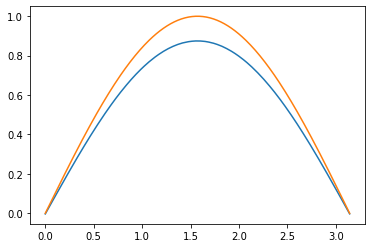

In [11]:
with torch.no_grad():
    prediction = cornn(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(19):
        prediction = cornn(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction
        



final_out = prediction.detach().numpy().reshape(-1,1)
final_true = u_exact[-1,:].reshape(-1,1)


x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

(256, 1)
torch.Size([256, 1])


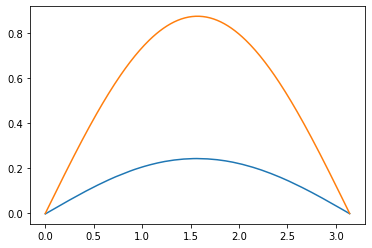

In [12]:

final_out = prediction_tensor[:, -5].detach().numpy().reshape(-1,1)
final_true = u_exact[-5,:].reshape(-1,1)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

In [13]:
prediction_tensor.shape
prediction_tensor = torch.squeeze(prediction_tensor)
print(prediction_tensor.shape)

torch.Size([20, 256])


In [14]:
# Exact Solution

u_test = u_exact
u_test_full = u_test[80:100, :]

### L2 norm

In [15]:
# Extrapolation

k1 = ( prediction_tensor - u_test_full)**2
u_test_full_tensor = u_test_full**2
u_test_full_tensor.shape

torch.Size([20, 256])

In [16]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.5368114142819826 %


### MAx absolute norm

In [17]:
R_abs = torch.max(torch.abs(prediction_tensor - u_test_full))
print(R_abs)

tensor(0.6768, dtype=torch.float64)


### explained variance score

In [18]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors


# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())

Explained Variance Score: 0.8037124789273179


In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(torch.abs(prediction_tensor - u_test_full))

print("Relative Error Test: ", relative_error_test, "%")

Relative Error Test:  tensor(0.2763, dtype=torch.float64) %


In [20]:
print(prediction_tensor.shape)

torch.Size([20, 256])


In [21]:
x1 = np.linspace(0, np.pi, 256)
t1 = np.linspace(0, 1, 99)

conc_u = torch.squeeze(input_tensor)
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)


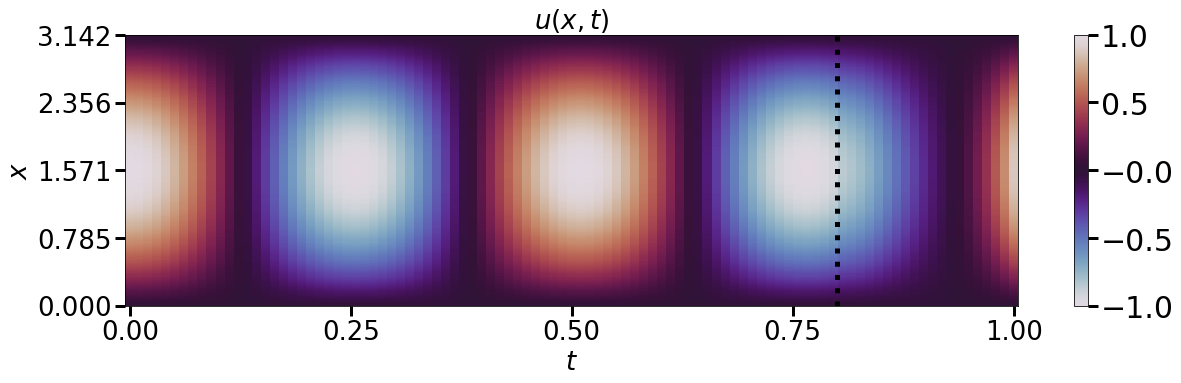

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(0, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x1, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='twilight')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=0.8, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_cornn_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### snapshots

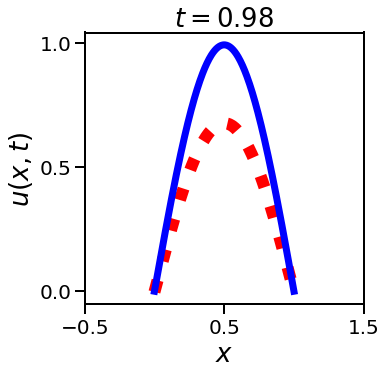

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed



final_time_output = prediction_tensor[-2, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_exact[-2, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.98}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-0.5, 0.5, 1.5])
ax.set_yticks([0, 0.5, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('cornn_0.98_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.98_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


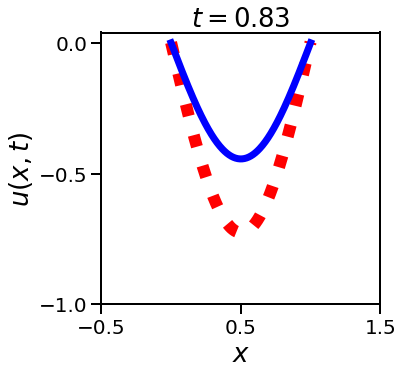

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed



final_time_output = prediction_tensor[3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_exact[83, :].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.83}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-0.5, 0.5, 1.5])
ax.set_yticks([-1, -0.5, 0])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('cornn_0.83_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.98_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
